In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table, vstack, join
from glob import glob
from tqdm import tqdm
import bokeh.plotting as bp
import warnings
import os

In [2]:
warnings.filterwarnings("ignore",category=SyntaxWarning)

In [32]:
import numpy as np
import numpy.ma as ma
import os
from scipy import stats
from scipy.optimize import curve_fit
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from glob import glob
plt.style.use('/Users/apitts4030/Repo/NaI_analysis/figures.mplstyle')
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1 import make_axes_locatable


import sys
sys.path.append("/Users/apitts4030/Repo/mangadap_muse/")
from mangadap.config import defaults

plt.rcParams['figure.figsize'] = (10,6)
plt.rc('axes', labelsize = 25)
plt.rc('axes', titlesize = 18)
#plt.rc('axes', titleweight = 'bold')
plt.rc('axes', lw = 2)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.rcParams['font.family'] = 'stixgeneral'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['xtick.minor.size'] = 8
plt.rcParams['ytick.minor.size'] = 8


class CubeData:

    def __init__(self, galname=None, bin_key=None, plate=None, ifu=None, nspax_list=None):
        self.galname = galname
        self.bin_key = bin_key
        self.nspax_list = nspax_list
        cubedir = f"/Users/apitts4030/Repo/NaI_analysis/data/{self.galname}/cube/{self.galname}-{self.bin_key}/NO-CORR/"
        fitsfils = glob(os.path.join(cubedir, "**", "*.fits"),recursive=True)
        cube_file_path = None
        maps_file_path = None
        for fil in fitsfils:
            if "LOGCUBE" in fil:
                cube_file_path = fil

            if "MAPS" in fil:
                maps_file_path = fil

        
        self.galname = galname
        self.bin_key = bin_key


        # output beta plot directory
        output_beta_dir = "paper/"
        self.output_beta_dir = output_beta_dir

        cube = fits.open(cube_file_path)
        maps = fits.open(maps_file_path)
        # bin ID has multiple layers of the same bin id map so use first one
        self.binid_map = maps['BINID'].data[0]
        # obtain wavelength, flux, model and error array from MUSE cube
        self.wave = cube['WAVE'].data
        self.flux = cube['FLUX'].data
        self.model = cube['MODEL'].data
        self.error = np.sqrt(1 / cube['IVAR'].data)

    def SN_dict(self):
        # create a dictionary containing that stores the number of spaxels in each bin ID
        # and beta values for each S/N bin
        SN_dict = {}
        SN_channel_keys = ['SN_range', 'bin_size', 'beta_bin']

        #SN_lims = [[0, 50], [50, 75], [75, 100], [100, 1000]]
        SN_lims = [[0, 15], [16, 30], [31, 60], [60, np.inf]]

        for i in range(len(SN_lims)):
            channel = f'SN_CHANNEL{i}'
            SN_dict[channel] = {}

            for key in SN_channel_keys:
                if key == 'SN_range':
                    SN_dict[channel][key] = SN_lims[i]
                else:
                    SN_dict[channel][key] = None

        return SN_dict

    def N_spx_dict(self):
        # create a dictionary containing the different N_spx bins
        N_spx_dict = {}
        N_spx_channel_keys = ['N_spx_range', 'SN_dict']
        
        #N_spx_lims = [[0, 5.5], [5.5, 22], [22, 52], [52, 122]]
        #N_spx_lims = [[1, 4], [4, 7], [7, 10], [10, 12]]
        N_spx_lims = [[1, 2], [3, 4], [5, 6], [7, 8], [9, np.inf]]

        #print(N_spx_lims)
        for i in range(len(N_spx_lims)):
            channel = f'N_spx_CHANNEL{i}'
            N_spx_dict[channel] = {}

            for key in N_spx_channel_keys:
                if key == 'N_spx_range':
                    N_spx_dict[channel][key] = N_spx_lims[i]
                # add S/N dictionary
                if key == 'SN_dict':
                    N_spx_dict[channel][key] = self.SN_dict()
        return N_spx_dict

    def beta_all_dict(self):
        # create a dictionary containing the different N_spx bins
        beta_all_dict = {}
        beta_all_channel_keys = ['SN_range', 'bin_size_all', 'beta_all', 'bin_modes', 'beta_medians', 'beta_stds']

        #SN_lims = [[0, 50], [50, 75], [75, 100], [100, 1000]]
        SN_lims = [[0, 15], [16, 30], [31, 60], [60, np.inf]]
        
        for i in range(len(SN_lims)):
            channel = f'SN_CHANNEL{i}'
            beta_all_dict[channel] = {}

            for key in beta_all_channel_keys:
                if key == 'SN_range':
                    beta_all_dict[channel][key] = SN_lims[i]

                elif (key == 'bin_size_all') or (key == 'beta_all'):
                    beta_all_dict[channel][key] = []

                else:
                    beta_all_dict[channel][key] = []

        return beta_all_dict

    def wv_dict(self):
        # create a dictionary for each wavelength channel
        wv_dict = {}
        wv_channel_keys = ['wv_range', 'bin_masks', 'N_spx', 'SN', 'beta', 'N_spx_dict', 'beta_all_dict']

        # wavelength ranges
        wv_lims = [[4751.42, 5212], [5212, 5672], [5672, 6132], [6132, 6592],
                   [6592, 7052], [7052, 7513], [7513, 7973], [7973, 8433], [8433, 8893], [8893, 9353.44]]

        for i in range(len(wv_lims)):
            channel = f'WAVE_CHANNEL{i}'
            wv_dict[channel] = {}

            for key in wv_channel_keys:
                if key == 'wv_range':
                    wv_dict[channel][key] = wv_lims[i]
                # add N_spx dictionary
                elif key == 'N_spx_dict':
                    wv_dict[channel][key] = self.N_spx_dict()
                # add Beta_all dictionary
                elif key == 'beta_all_dict':
                    wv_dict[channel][key] = self.beta_all_dict()
                else:
                    wv_dict[channel][key] = None

        return wv_dict

    def filter_data(self, array, conditional_array, lim):
        # filter out the input array based on the conditional array and input limits
        return array[(conditional_array >= lim[0]) & (conditional_array <= lim[1])]

    def apply_mask(self, wave_bin, flux_bin, model_bin, error_bin):
        # mask for large unaccounted emission or absorption lines if present

        # calculate the standard deviation in the fit residuals (rN)
        # https://quantifyinghealth.com/residual-standard-deviation-error/ for reference
        rN_1sigma = np.sqrt(np.mean((flux_bin - model_bin) ** 2))
        # calculate rN per pixel
        rN = np.sqrt((flux_bin - model_bin) ** 2)

        # perform a rudimentary sigma clip and
        # mask indices where the residual noise exceeds 10 sigma
        wave_mask = ma.masked_where(rN / rN_1sigma >= 10, wave_bin)
        flux_mask = ma.masked_where(rN / rN_1sigma >= 10, flux_bin)
        model_mask = ma.masked_where(rN / rN_1sigma >= 10, model_bin)
        error_mask = ma.masked_where(rN / rN_1sigma >= 10, error_bin)

        return wave_mask, flux_mask, model_mask, error_mask

    def calc_beta(self, wave, flux, model, error, binid_map):
        # calculate number of spaxels, S/N and correlation ratio value for each bin ID

        # total number of bins
        n_bins = np.max(binid_map) + 1

        bin_masks = []
        bin_sizes = np.zeros(n_bins)
        sn = np.zeros(n_bins)
        betas = np.zeros(n_bins)

        for i in range(n_bins):
            id_mask = binid_map == i
            # get bin sizes, S/N and beta value for each bin ID
            n_spx = len(flux[:, id_mask][0, :])
            #if n_spx not in [3, 6, 9, 12]:
             #   continue
            #print(n_spx)
            # get flux, stellar continuum model and variance array from bin ID
            # print(flux)
            flux_bin = flux[:, id_mask][:, 0]
            model_bin = model[:, id_mask][:, 0]
            error_bin = error[:, id_mask][:, 0]

            # mask values
            wave_mask, flux_mask, model_mask, error_mask = self.apply_mask(wave, flux_bin, model_bin,
                                                                           error_bin)

            # calculate the S/N and correlation ratio with the masked data
            snr = np.median(flux_mask / error_mask)
            # calculate the standard deviation in the fit residuals (rN)
            rN_1sigma = np.sqrt(np.mean((flux_mask - model_mask) ** 2))
            # calculate the correlation ratio (between residual noise
            # and propagated noise (beta = rN/N)
            beta = (rN_1sigma / np.median(error_mask))

            # don't store correlation ratio if its non-finite and less than 0
            if (np.isfinite(beta) == False) or (beta < 0) or (beta > 100):
                continue
            else:
                bin_masks.append(flux_mask.mask)
                bin_sizes[i] = n_spx
                sn[i] = snr
                betas[i] = beta
        return bin_masks, bin_sizes, sn, betas

    def get_beta(self):
        # dictionary for each wavelength channel
        self.wv_dict = self.wv_dict()

        for wv_key in self.wv_dict.keys():
            # filter data
            # wave_filt, flux_filt, model_filt, err_filt = self.filter_data(self.wv_dict[key]['wv_range'])
            wave_filt = self.filter_data(self.wave, self.wave, self.wv_dict[wv_key]['wv_range'])
            flux_filt = self.filter_data(self.flux, self.wave, self.wv_dict[wv_key]['wv_range'])
            model_filt = self.filter_data(self.model, self.wave, self.wv_dict[wv_key]['wv_range'])
            err_filt = self.filter_data(self.error, self.wave, self.wv_dict[wv_key]['wv_range'])

            # get number of spaxels in each bin, S/N and beta value for each bin ID
            bin_masks, bin_sizes, sn, betas = self.calc_beta(wave_filt, flux_filt,
                                                             model_filt, err_filt, self.binid_map)
            # save the mask from each bin ID
            self.wv_dict[wv_key]['bin_masks'] = bin_masks

            # loop through and place each spaxel bin size and beta value into their respective
            # N_spx and S/N bin
            N_spx_dict = self.wv_dict[wv_key]['N_spx_dict']
            beta_all_dict = self.wv_dict[wv_key]['beta_all_dict']

            for N_spx_key in N_spx_dict.keys():
                # filter bin size, S/N and beta values according to number of spaxel (N_spx) range
                bin_sizes_N_spx_filt = self.filter_data(bin_sizes,
                                                        bin_sizes, N_spx_dict[N_spx_key]['N_spx_range'])
                #print("-----------")
                #print(f"n_spax range: {N_spx_dict[N_spx_key]['N_spx_range']}")
                #print(np.unique(bin_sizes_N_spx_filt))
                
                sn_N_spx_filt = self.filter_data(sn,
                                                 bin_sizes, N_spx_dict[N_spx_key]['N_spx_range'])
                beta_N_spx_filt = self.filter_data(betas,
                                                   bin_sizes, N_spx_dict[N_spx_key]['N_spx_range'])

                SN_dict = N_spx_dict[N_spx_key]['SN_dict']
                for SN_key in SN_dict.keys():
                    # filter bin size and beta values according to S/N range
                    bin_size_SN_filt = self.filter_data(bin_sizes_N_spx_filt,
                                                        sn_N_spx_filt, SN_dict[SN_key]['SN_range'])

                    #print(f"S/N range: {SN_dict[SN_key]['SN_range']}")
                    #print(np.unique(bin_size_SN_filt))
                    
                    beta_SN_filt = self.filter_data(beta_N_spx_filt,
                                                    sn_N_spx_filt, SN_dict[SN_key]['SN_range'])
                    # save the data
                    SN_dict[SN_key]['bin_size'] = bin_size_SN_filt
                    SN_dict[SN_key]['beta_bin'] = beta_SN_filt

                N_spx_dict[N_spx_key]['SN_dict'] = SN_dict

            for all_key in beta_all_dict.keys():
                for N_spx_key in N_spx_dict.keys():
                    bin_size = N_spx_dict[N_spx_key]['SN_dict'][all_key]['bin_size']
                    beta_bin = N_spx_dict[N_spx_key]['SN_dict'][all_key]['beta_bin']

                    beta_all_dict[all_key]['bin_size_all'].append(bin_size)
                    beta_all_dict[all_key]['beta_all'].append(beta_bin)

            for all_key in beta_all_dict.keys():
                #print(f"all key: {all_key}")
                
                bin_size_all = beta_all_dict[all_key]['bin_size_all']
                beta_all = beta_all_dict[all_key]['beta_all']

                #print(all_key)
                #print(bin_size_all)
                for bin_array, beta_array in zip(bin_size_all, beta_all):
                    if len(bin_array) == 0:
                        #print('true')
                        beta_all_dict[all_key]['bin_modes'].append(-999)
                        beta_all_dict[all_key]['beta_medians'].append(-999)
                        beta_all_dict[all_key]['beta_stds'].append(-999)

                    else:
                        #print(stats.mode(bin_array)[0])
                        beta_all_dict[all_key]['bin_modes'].append(stats.mode(bin_array)[0])
                        beta_all_dict[all_key]['beta_medians'].append(np.median(beta_array))
                        beta_all_dict[all_key]['beta_stds'].append(np.std(beta_array))

            self.wv_dict[wv_key]['N_spx_dict'] = N_spx_dict
            self.wv_dict[wv_key]['beta_all_dict'] = beta_all_dict

    # Sarzi+2018 quadratic function
    def beta_func_quad(self, N_spx, a, b):
        return 1 + a * (np.log10(N_spx)) ** b

    def create_beta_tables(self):

        # dictionary for each wavelength channel
        wv_dict = self.wv_dict

        return_dict = {}
        for wv_key in tqdm(wv_dict.keys()):
            print(f"####################################")
            print(f"########### {wv_key} ###########")
            print(f"####################################")
            # dictionary for each wavelength channel
            wv_range = wv_dict[wv_key]['wv_range']
            beta_all_dict = wv_dict[wv_key]['beta_all_dict']

            # list to store median beta values to write into .dat file
            beta_table_data = []

            # list to store for values for fitting Sarzi+2018 relation
            bin_fit = []
            beta_fit = []
            beta_err = []

            temp_dict = {}
            for i in [1,2,3,4,5,6,7,8,9,10,12]:
                key = str(i)
                temp_dict[key] = None
            # loop through each S/N channel within Beta_all dicitonary
            for all_key in beta_all_dict.keys():
                bin_modes = beta_all_dict[all_key]['bin_modes']
                beta_medians = beta_all_dict[all_key]['beta_medians']
                beta_stds = beta_all_dict[all_key]['beta_stds']
                
                # don't keep last beta median value because the correlation
                # correction does not do well for N_spx > 100
                beta_table_data.append(beta_medians)
                
                for bin_mode, beta_median, beta_std in zip(bin_modes, beta_medians, beta_stds):

                    if beta_std == 0:
                        beta_std=1
                    if bin_mode == -999:
                        continue
                    else:
                        bin_fit.append(bin_mode)
                        beta_fit.append(beta_median)
                        beta_err.append(beta_std)

            beta_func_quad = self.beta_func_quad
            # get parameters
            # fit data points usings Sarzi+2018 relationshiop
            print(f"Bins: {bin_fit}")
            print(f"Betas: {beta_fit}")
            print(f"Errs: {beta_err}")
            popt_sarzi, pcov_sarzi = curve_fit(beta_func_quad, np.array(bin_fit),np.array(beta_fit), sigma=np.array(beta_err))

            print("@@ Best Fit @@")
            print(f"a = {popt_sarzi[0]} +/- {np.sqrt(np.diag(pcov_sarzi))[0]}")
            print(f"b = {popt_sarzi[1]} +/- {np.sqrt(np.diag(pcov_sarzi))[1]}")

            for key in temp_dict.keys():
                #temp_dict[key] = [popt_sarzi[0],popt_sarzi[1],1 + popt_sarzi[0] * (np.log10(float(key))) ** popt_sarzi[1]]
                temp_dict[key] = 1 + popt_sarzi[0] * (np.log10(float(key))) ** popt_sarzi[1]
            #print(f"{wv_range}: a = {popt_sarzi[0]:.3f}, b = {popt_sarzi[1]:.3f}, beta = {(1 + popt_sarzi[0] * (np.log10(9)) ** popt_sarzi[1]):.3f}")
            return_dict[wv_key] = temp_dict
            # create an Astropy data table containting each median beta histogram distribution
            # for a given S/N and N_spx size
            names = ('S_N_0-15', 'S_N_16-30', 'S_N_31-60', 'S_N_60-inf', 'param_fit_a', 'param_fit_b')

            nrows = len(beta_table_data[0]) - 1
            param_fit_a = [popt_sarzi[0]] + [-999] * nrows
            param_fit_b = [popt_sarzi[1]] + [-999] * nrows
            
            beta_table = Table([beta_table_data[0], beta_table_data[1], beta_table_data[2], beta_table_data[3],
                                param_fit_a, param_fit_b],
                               names=names)

            self.wv_dict[wv_key]['beta_table'] = beta_table

            # write the beta table into a .dat file
            beta_tables_dir = os.path.join(defaults.dap_data_root(), 'beta_tables')
            beta_tables_gal_dir = os.path.join(beta_tables_dir, f'{self.galname}-{self.bin_key}')
            if not os.path.isdir(beta_tables_gal_dir):
                os.makedirs(beta_tables_gal_dir)

            # create the file name
            file_name = f'beta_corr_{wv_range[0]}_{wv_range[1]}.dat'
            beta_table_path = os.path.join(beta_tables_gal_dir, file_name)
            beta_table.write(beta_table_path, format='ascii', overwrite=True)
            logging.info(f'Writing {file_name} to {beta_tables_gal_dir}')

        return return_dict

    def mk_residual_plot(self, wv_channel, bin_id, zoom=None):
        # plot the flux, model and error in main plot
        # lower plot showcases the ratio between the residual-noise-per-pixel and
        # 1 standard deviation of the residual noise over the entire wavelength channel (rN/1sigma_rN)

        # wavelength channel dictionary
        wv_dict = self.wv_dict[f'WAVE_CHANNEL{wv_channel}']
        # mask array
        mask_bin = wv_dict['bin_masks'][bin_id]

        wave_bin = self.wave
        # get flux, stellar continuum model and variance array from bin ID
        id_mask = self.binid_map == bin_id
        flux_bin = self.flux[:, id_mask][:, 0]
        model_bin = self.model[:, id_mask][:, 0]
        error_bin = self.error[:, id_mask][:, 0]

        # filter out data and apply mask from bin ID
        wave = ma.masked_array(self.filter_data(wave_bin, wave_bin, wv_dict['wv_range']), mask=mask_bin)
        flux = ma.masked_array(self.filter_data(flux_bin, wave_bin, wv_dict['wv_range']), mask=mask_bin)
        model = ma.masked_array(self.filter_data(model_bin, wave_bin, wv_dict['wv_range']), mask=mask_bin)
        err = ma.masked_array(self.filter_data(error_bin, wave_bin, wv_dict['wv_range']), mask=mask_bin)

        # 1 sigma residual noise before and afer being masked
        rN_1sigma_unmasked = np.sqrt(np.mean((flux.data - model.data) ** 2))
        rN_1sigma_masked = np.sqrt(np.mean((flux - model) ** 2))

        # show good and bad beta values per pixel before being masked
        beta_good_unmasked = rN_1sigma_unmasked / err
        beta_bad_unmasked = rN_1sigma_unmasked / err.data

        # show beta values after being masked
        beta_good_masked = rN_1sigma_masked / err.data

        # make plots
        fig = plt.figure(figsize=(10, 6))

        # create an extra masked plot if there are masked pixels
        if flux.mask.any() == True:
            gs = fig.add_gridspec(3, hspace=0, height_ratios=(3, 1, 1))
            axs = gs.subplots(sharex=True)
        else:
            gs = fig.add_gridspec(2, hspace=0, height_ratios=(3, 1))
            axs = gs.subplots(sharex=True)

        axs[0].set_title(f'Wavelength Channel {wv_channel} ({wv_dict["wv_range"][0]}-'
                         f'{wv_dict["wv_range"][1]} $\mathrm{{\AA}}$)', fontsize=22)

        axs[0].step(wave.data, flux.data, c='k', zorder=2, label='Data')
        axs[0].step(wave.data, model.data, c='tab:purple', zorder=3, label='Model')
        axs[0].step(wave.data, err.data, c='tab:green', zorder=1, label='Error')
        axs[0].set_ylabel(r'Flux ($10^{-20} \mathrm{erg}$ $\mathrm{cm}^{-2}$ $\mathrm{s}^{-1}$)', fontsize=19)
        axs[0].set_ylim(-0.01, np.median(flux) * 1.25)

        if flux.mask.any() == True:

            # manually define a patch for the masked region
            ax0_handles, labels = axs[0].get_legend_handles_labels()
            mask_patch = mpatches.Patch(color='cadetblue', label='Masked Region', alpha=0.3)
            # append manual patch
            ax0_handles.append(mask_patch)
            axs[0].legend(handles=ax0_handles, fontsize='large', loc='center left')

            # plot beta values before being maksed
            axs[1].step(wave, beta_good_unmasked,
                        label=r'$\beta$ Before Masking', c='grey', zorder=2)
            # plot bad beta values
            axs[1].step(wave.data, beta_bad_unmasked,
                        label=r'Masked Pixels', c='r', zorder=1)

            axs[1].set_ylabel(r'$\beta$', fontsize=20)
            axs[1].set_ylim(-0.5, np.median(beta_good_unmasked) * 2.2)
            axs[1].legend(fontsize='large', frameon=False, loc='upper left', ncol=2)

            # plot beta values after being masked
            axs[2].step(wave.data, beta_good_masked,
                        label=r'$\beta$ After Masking', c='grey', zorder=1)

            axs[2].set_xlabel(r'Wavelength ($\mathrm{\AA}$)', fontsize=20)
            axs[2].set_ylabel(r'$\beta$', fontsize=20)
            axs[2].set_ylim(-0.5, np.median(beta_good_unmasked) * 2.2)
            axs[2].legend(fontsize='large', frameon=False, loc='upper left')

            # highlight masked regions
            pix_size = wave.data[1] - wave.data[0]
            for masked_pix in wave.data[wave.mask]:
                axs[0].axvspan(masked_pix - (pix_size / 1), masked_pix, alpha=0.3,
                               color='cadetblue', zorder=4)
                axs[1].axvspan(masked_pix - (pix_size / 1), masked_pix, alpha=0.3,
                               color='cadetblue', zorder=4)
                axs[2].axvspan(masked_pix - (pix_size / 1), masked_pix, alpha=0.3,
                               color='cadetblue', zorder=4)

            if zoom is not None:
                axs[0].set_xlim(zoom[0], zoom[1])
                axs[1].set_xlim(zoom[0], zoom[1])
                axs[2].set_xlim(zoom[0], zoom[1])

        else:
            # only create one beta plot if theres no masking
            logging.info('No masked pixels!')

            # create legend without masked region patch
            axs[0].legend(fontsize='large', loc='center left')

            # plot beta values before being maksed
            axs[1].step(wave, beta_good_masked, c='grey', zorder=1)

            axs[1].set_xlabel(r'Wavelength ($\mathrm{\AA}$)', fontsize=20)
            axs[1].set_ylabel(r'$\beta$', fontsize=20)
            axs[1].set_ylim(-0.5, np.median(beta_good_masked) * 2.2)

            # zoom must be a list with two wavelegnth values in it
            if zoom is not None:
                axs[0].set_xlim(zoom[0], zoom[1])
                axs[1].set_xlim(zoom[0], zoom[1])

    def mk_hist_plot(self, wv_channel, show_plot=True, save_plot=False):
        # wavelength channel dictionary
        wv_dict = self.wv_dict[f'WAVE_CHANNEL{wv_channel}']

        beta_bins = np.arange(0, 15, 0.2)
        #median_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
        median_colors = ['peachpuff', 'steelblue', 'slategray', 'lavender']

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
        fig.tight_layout(pad=4.0)

        N_spx_dict = wv_dict['N_spx_dict']

        for N_spx_key, ax in zip(N_spx_dict.keys(), fig.get_axes()):
            N_spx_range = N_spx_dict[N_spx_key]['N_spx_range']
            SN_dict = N_spx_dict[N_spx_key]['SN_dict']

            for i, SN_key in enumerate(SN_dict.keys()):
                SN_range = SN_dict[SN_key]['SN_range']
                beta_SN_bin = SN_dict[SN_key]['beta_bin']

                if SN_key == 'SN_CHANNEL3':
                    label = f'{SN_range[0]} < SN'
                else:
                    label = f'{SN_range[0]} < SN < {SN_range[1]}'

                ax.hist(beta_SN_bin, bins=beta_bins, label=label, color=median_colors[i],
                        histtype='step', stacked=False, alpha=0.9, fill=False)
                ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, length=5)
                ax.set_xticks(np.arange(1, 10))

                if np.isnan(np.median(beta_SN_bin)) == True:
                    continue
                else:
                    ax.axvline(np.median(beta_SN_bin), ls='--', c=median_colors[i], lw=1)

            if N_spx_key == 'N_spx_CHANNEL0':
                ax.set_title(f'$N_{{ \mathrm{{spax}} }}$ < {N_spx_range[1]}', fontsize=22)
                ax.legend(fontsize=16)

            elif N_spx_key == 'N_spx_CHANNEL3':
                ax.set_title(f'$N_{{ \mathrm{{spax}} }}$ > {N_spx_range[1]}', fontsize=22)

            else:
                ax.set_title(f'{N_spx_range[0]} < $N_{{\mathrm{{spax}}}}$ < {N_spx_range[1]}', fontsize=22)

            ax.set_xlim(0, 10)
            ax.set_xlabel(r'$\beta$ (rN/N)', fontsize=22)
            ax.set_ylabel('Counts')

        fig.suptitle(f' $\\beta$ Histograms for Wavelength Channel {wv_channel} ({wv_dict["wv_range"][0]}-'
                     f'{wv_dict["wv_range"][1]} $\mathrm{{\AA}}$)', fontsize=25, y=1.03)

        # save the figure if save_plot is True
        if save_plot:
            # create historgram directory if it doesn't exist already
            beta_hist_dir = os.path.join(self.output_beta_dir, 'beta_histogram_plots')
            if not os.path.isdir(beta_hist_dir):
                os.makedirs(beta_hist_dir)

            file_name = f'beta_hist_{wv_dict["wv_range"][0]}_{wv_dict["wv_range"][1]}.png'
            # save the figure image
            fig.savefig(f'{beta_hist_dir}/{file_name}', bbox_inches='tight')
            logging.info(f'Saving {file_name} to {beta_hist_dir}')

        # don't show the plot if show_plot is False
        if not show_plot:
            plt.close()
            logging.info('Not displaying plot!')

    def mk_violin_plot(self, wv_channel, show_plot=True, save_plot=False):
        # create violin plots for each wavelength channel

        # dictionary containing all the bin sizes and beta values for each
        # wavelength channel
        beta_all_dict = self.wv_dict[f'WAVE_CHANNEL{wv_channel}']['beta_all_dict']

        # slightly offset each violin plot within the same S/N channel
        #x_offset = [-3, -1, 1, 3]
        x_offset = [0,0,0,0]
        colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
        # get all the bin modes for each S/N channel
        bin_mode_all = []

        plt.figure(figsize=(10, 6))
        # legend patches
        color_patches = []
        color_patches.append(plt.Line2D([], [], color='k', ls="--", label='Sarzi+2018'))

        # loop through each S/N channel and create a violin plot
        # for each non-zero array using the beta distribution and bin size mode
        for i, SN_key in enumerate(beta_all_dict.keys()):
            SN_range = beta_all_dict[SN_key]['SN_range']
            bin_modes = np.array(beta_all_dict[SN_key]['bin_modes'])
            beta_all = beta_all_dict[SN_key]['beta_all']

            # check to see if there are any beta distributions for the given
            # S/N range
            if np.all(bin_modes == -999):
                logging.info(f'No beta distributions for S/N range between {SN_range[0]}-{SN_range[1]}')
                continue
            else:
                for bin_mode, betas in zip(bin_modes, beta_all):
                    # if array empty, skip
                    if bin_mode == -999:
                        continue
                    else:
                        bin_mode_all.append(bin_mode)
                        violinplots = plt.violinplot(betas, positions=[bin_mode + x_offset[i]],
                                                     showmedians=True, widths=7)
                        plt.scatter(bin_mode, np.median(betas), marker='o', s=7, c=colors[i], edgecolors='k')
                        # configure each individiual violin plot colors
                        for partname in ('cbars', 'cmins', 'cmaxes', 'cmedians', 'bodies'):
                            violin = violinplots[partname]
                            if partname == 'bodies':
                                for vp in violin:
                                    vp.set_color(colors[i])
                                    vp.set_facecolor(colors[i])
                                    vp.set_edgecolor(colors[i])
                                    vp.set_alpha(0.2)
                                    vp.set_label('uhh')

                            else:
                                violin.set_edgecolor(colors[i])
                                violin.set_linewidth(2)

                        if SN_key == 'SN_CHANNEL3':
                            SN_str = f'{SN_range[0]} < SN'
                        else:
                            SN_str = f'{SN_range[0]} < SN < {SN_range[1]}'

                        # add to legend handle
                        if bin_modes[bin_modes > -999][-1] == bin_mode:
                            c_patch = mpatches.Patch(color=colors[i], label=SN_str)
                            color_patches.append(c_patch)

        # Sarzi+2018 fit parameters
        a = self.wv_dict[f'WAVE_CHANNEL{wv_channel}']['beta_table']['param_fit_a'][0]
        b = self.wv_dict[f'WAVE_CHANNEL{wv_channel}']['beta_table']['param_fit_b'][0]

        # show Sarzi relation against violin plots
        N_spx_range = np.arange(0, bin_mode_all[-1] + x_offset[-1] + 1)
        plt.plot(N_spx_range, self.beta_func_quad(N_spx_range, a, b), c='k', ls='--', label='Sarzi+2018')

        plt.tick_params(axis='both', which='both', direction='in', top=True, right=True, length=7)
        plt.ylabel(r'$\beta$ (rN/N)')
        plt.xlabel('Mode $N_{spx}$')
        # {x:.2f}
        plt.legend(handles=color_patches, fontsize='xx-large', loc='upper center', frameon=False)

        plt.figtext(x=0.15, y=0.50, s='Parameter Fits\n', fontsize=16)
        text_str = f'a = {a:.2f}, b = {b:.2f}'
        plt.figtext(x=0.15, y=0.49, s=text_str, fontsize=16)

        wv_range = self.wv_dict[f'WAVE_CHANNEL{wv_channel}']["wv_range"]
        plt.title(f'Wavelength Channel {wv_channel} ({wv_range[0]}-'
                  f'{wv_range[1]} $\mathrm{{\AA}}$)', fontsize=22)

        # save the figure if save_plot is True
        if save_plot:
            # create historgram directory if it doesn't exist already
            beta_violin_dir = os.path.join(self.output_beta_dir, 'beta_violin_plots')
            if not os.path.isdir(beta_violin_dir):
                os.makedirs(beta_violin_dir)

            file_name = f'beta_violin_{wv_range[0]}_{wv_range[1]}.png'
            # save the figure image
            plt.savefig(f'{beta_violin_dir}/{file_name}', bbox_inches='tight')
            logging.info(f'Saving {file_name} to {beta_violin_dir}')

        # don't show the plot if show_plot is False
        if not show_plot:
            plt.close()

    def mk_hist_plots(self, show_plots=False, save_plots=True):

        # create histogram plots for all the wavelength channels
        for i in range(len(self.wv_dict.keys())):
            self.mk_hist_plot(wv_channel=i, show_plot=show_plots, save_plot=save_plots)

    def mk_violin_plots(self, show_plots=False, save_plots=True):

        # create violin plots for all the wavelength channels
        for i in range(len(self.wv_dict.keys())):
            self.mk_violin_plot(wv_channel=i, show_plot=show_plots, save_plot=save_plots)

##############################################################################################################
##############################################################################################################



    def mk_violin_plot_paper(self, wv_channel, show_plot=True, save_plot=False):
        # create violin plots for each wavelength channel

        # dictionary containing all the bin sizes and beta values for each
        # wavelength channel
        beta_all_dict = self.wv_dict[f'WAVE_CHANNEL{wv_channel}']['beta_all_dict']

        # slightly offset each violin plot within the same S/N channel
        x_offset = [-3, -1, 1, 3]
        #colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
        colors = ['xkcd:raspberry', 'xkcd:dark beige', 'xkcd:dark slate blue', 'xkcd:dark mint green']
        # get all the bin modes for each S/N channel
        bin_mode_all = []

        plt.figure(figsize=(10, 6))
        # legend patches
        color_patches = []
        color_patches.append(plt.Line2D([], [], color='k', ls="--", label='Sarzi+2018'))

        # loop through each S/N channel and create a violin plot
        # for each non-zero array using the beta distribution and bin size mode
        for i, SN_key in enumerate(beta_all_dict.keys()):
            SN_range = beta_all_dict[SN_key]['SN_range']
            bin_modes = np.array(beta_all_dict[SN_key]['bin_modes'])
            beta_all = beta_all_dict[SN_key]['beta_all']

            # check to see if there are any beta distributions for the given
            # S/N range
            if np.all(bin_modes == -999):
                logging.info(f'No beta distributions for S/N range between {SN_range[0]}-{SN_range[1]}')
                continue
            else:
                for bin_mode, betas in zip(bin_modes, beta_all):
                    # if array empty, skip
                    if bin_mode != 9:
                        continue
                    else:
                        bin_mode_all.append(bin_mode)
                        violinplots = plt.violinplot(betas, positions=[bin_mode + x_offset[i]],
                                                     showmedians=True, widths=7)

                        # configure each individiual violin plot colors
                        for partname in ('cbars', 'cmins', 'cmaxes', 'cmedians', 'bodies'):
                            violin = violinplots[partname]
                            if partname == 'bodies':
                                for vp in violin:
                                    vp.set_color(colors[i])
                                    vp.set_facecolor(colors[i])
                                    vp.set_edgecolor(colors[i])
                                    vp.set_alpha(0.2)
                                    #vp.set_label('uhh')L

                            else:
                                violin.set_edgecolor(colors[i])
                                violin.set_linewidth(2)

                        if SN_key == 'SN_CHANNEL3':
                            SN_str = f'{SN_range[0]} < SN'
                        else:
                            SN_str = f'{SN_range[0]} < SN < {SN_range[1]}'

                        # add to legend handle
                        if bin_modes[bin_modes > -999][-1] == bin_mode:
                            c_patch = mpatches.Patch(color=colors[i], label=SN_str)
                            color_patches.append(c_patch)

        # Sarzi+2018 fit parameters
        a = self.wv_dict[f'WAVE_CHANNEL{wv_channel}']['beta_table']['param_fit_a'][0]
        b = self.wv_dict[f'WAVE_CHANNEL{wv_channel}']['beta_table']['param_fit_b'][0]

        # show Sarzi relation against violin plots
        N_spx_range = np.arange(0, bin_mode_all[-1] + x_offset[-1] + 1)
        plt.plot(N_spx_range, self.beta_func_quad(N_spx_range, a, b), c='k', ls='--', label='Sarzi+2018')

        plt.tick_params(axis='both', which='both', direction='in', top=True, right=True, length=7)
        plt.ylabel(r'$\beta$ (rN/N)')
        plt.xlabel('Mode $N_{spx}$')
        # {x:.2f}
        plt.legend(handles=color_patches, fontsize='xx-large', loc='upper center', frameon=False)

        plt.figtext(x=0.15, y=0.50, s='Parameter Fits\n', fontsize=16)
        text_str = f'a = {a:.2f}, b = {b:.2f}'
        plt.figtext(x=0.15, y=0.49, s=text_str, fontsize=16)

        wv_range = self.wv_dict[f'WAVE_CHANNEL{wv_channel}']["wv_range"]
        #plt.title(f'Wavelength Channel {wv_channel} ({wv_range[0]}-'
         #         f'{wv_range[1]} $\mathrm{{\AA}}$)', fontsize=22)

        # save the figure if save_plot is True
        if save_plot:
            # create historgram directory if it doesn't exist already
            beta_violin_dir = "paper/paper-plots/NGC4030"

            file_name = f'beta_violin_NGC4030_{wv_range[0]}_{wv_range[1]}.png'
            # save the figure image
            plt.savefig(f'{beta_violin_dir}/{file_name}', bbox_inches='tight',dpi=400)
            logging.info(f'Saving {file_name} to {beta_violin_dir}')

        # don't show the plot if show_plot is False
        if not show_plot:
            plt.close()

##############################################################################################################
##############################################################################################################

    
    def mk_hist_plot_paper(self, wv_channel, show_plot=True, save_plot=False):
        # wavelength channel dictionary
        wv_dict = self.wv_dict[f'WAVE_CHANNEL{wv_channel}']

        beta_bins = np.arange(0, 15, 0.2)
        #median_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
        median_colors = ['xkcd:raspberry', 'xkcd:dark beige', 'xkcd:dark slate blue', 'xkcd:dark mint green']

        plt.figure()
        
        #fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
        #fig.tight_layout(pad=4.0)

        N_spx_dict = wv_dict['N_spx_dict']

    #for N_spx_key, ax in zip(N_spx_dict.keys(), fig.get_axes()):
        N_spx_key = 'N_spx_CHANNEL1'
        N_spx_range = N_spx_dict[N_spx_key]['N_spx_range']
        SN_dict = N_spx_dict[N_spx_key]['SN_dict']
        for i, SN_key in enumerate(SN_dict.keys()):
            SN_range = SN_dict[SN_key]['SN_range']
            beta_SN_bin = SN_dict[SN_key]['beta_bin']

            if SN_key == 'SN_CHANNEL3':
                label = f'{SN_range[0]} < SN'
            else:
                label = f'{SN_range[0]} < SN < {SN_range[1]}'

            plt.hist(beta_SN_bin, bins=beta_bins, label=label, color=median_colors[i], linewidth=2,
                    histtype='step', stacked=False, alpha=1, fill=False)
            plt.tick_params(axis='both', which='both', direction='in', top=True, right=True, length=5)
            plt.xticks(np.arange(1, 10))

            if np.isnan(np.median(beta_SN_bin)) == True:
                continue
            else:
                plt.vlines(np.median(beta_SN_bin), ymin=0, ymax=800, linestyles='--', colors=median_colors[i], linewidths=1.5)

        #if N_spx_key == 'N_spx_CHANNEL0':
            #ax.set_title(f'$N_{{ \mathrm{{spax}} }}$ < {N_spx_range[1]}', fontsize=22)
            plt.legend(fontsize=20,frameon=False)

        #elif N_spx_key == 'N_spx_CHANNEL3':
         #   ax.set_title(f'$N_{{ \mathrm{{spax}} }}$ > {N_spx_range[1]}', fontsize=22)

        #else:
         #   ax.set_title(f'{N_spx_range[0]} < $N_{{\mathrm{{spax}}}}$ < {N_spx_range[1]}', fontsize=22)

        plt.xlim(0, 10)
        plt.xlabel(r'$\beta$ (rN/N)', fontsize=22)
        plt.ylabel('Counts')

        #fig.suptitle(f' $\\beta$ Histograms for Wavelength Channel {wv_channel} ({wv_dict["wv_range"][0]}-'
         #            f'{wv_dict["wv_range"][1]} $\mathrm{{\AA}}$)', fontsize=25, y=1.03)

        # save the figure if save_plot is True
        if save_plot:
            # create historgram directory if it doesn't exist already
            beta_hist_dir = "paper/paper-plots/NGC4030"
            file_name = f'beta_hist_NGC4030_{wv_dict["wv_range"][0]}_{wv_dict["wv_range"][1]}.png'
            # save the figure image
            plt.savefig(f'{beta_hist_dir}/{file_name}', bbox_inches='tight',dpi=400)
            logging.info(f'Saving {file_name} to {beta_hist_dir}')

        # don't show the plot if show_plot is False
        if not show_plot:
            plt.close()
            logging.info('Not displaying plot!')



##############################################################################################################
##############################################################################################################
##############################################################################################################
##############################################################################################################
    

    def make_scatter_plot(self, wv_channel, show_plot=False, save_plot=False):
        beta_all_dict = self.wv_dict[f'WAVE_CHANNEL{wv_channel}']['beta_all_dict']
        wv_dict = self.wv_dict[f'WAVE_CHANNEL{wv_channel}']
        beta_bins = np.arange(0, 15, 0.2)
        N_spx_dict = wv_dict['N_spx_dict']

        colors = ['xkcd:raspberry', 'xkcd:dark beige', 'xkcd:dark slate blue', 'xkcd:dark mint green']
        bin_mode_all = []
        
        color_patches = []
        color_patches.append(plt.Line2D([], [], color='k', ls="--", label='Sarzi+2018'))



        fig, ax = plt.subplots(1,2, figsize=(8,4), sharey=True)
        plt.subplots_adjust(wspace=0)

        #x1, x2, y1, y2 = 8.8, 9.2, 2, 2.6
        #axins = ax[0].inset_axes([.12,.37,.33,.33], xlim=(x1,x2),ylim=(y1,y2))
        for N_spx_key in N_spx_dict.keys():
            #N_spx_key = 'N_spx_CHANNEL1'
            N_spx_range = N_spx_dict[N_spx_key]['N_spx_range']
            SN_dict = N_spx_dict[N_spx_key]['SN_dict']
            for i, SN_key in enumerate(SN_dict.keys()):
                SN_range = SN_dict[SN_key]['SN_range']
                beta_SN_bin = SN_dict[SN_key]['beta_bin']
    
                if SN_key == 'SN_CHANNEL3':
                    label = f'{SN_range[0]} < SN'
                else:
                    label = f'{SN_range[0]} < SN < {SN_range[1]}'
    
                ax[1].hist(beta_SN_bin, bins=beta_bins, label=label, color=colors[i], linewidth=2,
                        histtype='step', stacked=False, alpha=1, fill=False, orientation='horizontal')
                ax[1].tick_params(axis='both', which='both', direction='in', top=True, right=True, length=5)
                #ax[1].set_xticks(np.arange(1, 10))
    
                if np.isnan(np.median(beta_SN_bin)) == True:
                    continue
                
                    #ax[1].axvline(np.median(beta_SN_bin), ls='--', c=colors[i], lw=1.5)
    
            #if N_spx_key == 'N_spx_CHANNEL0':
                #ax.set_title(f'$N_{{ \mathrm{{spax}} }}$ < {N_spx_range[1]}', fontsize=22)
    
            #elif N_spx_key == 'N_spx_CHANNEL3':
             #   ax.set_title(f'$N_{{ \mathrm{{spax}} }}$ > {N_spx_range[1]}', fontsize=22)
    
            #else:
             #   ax.set_title(f'{N_spx_range[0]} < $N_{{\mathrm{{spax}}}}$ < {N_spx_range[1]}', fontsize=22)

        #ax[1].set_ylim(0, 10)
        #ax[1].set_ylabel(r'$\beta$ (rN/N)', fontsize=22)
        ax[1].set_xlabel('Counts')
        #ax[1].legend(fontsize=13,frameon=False)

        #fig.suptitle(f' $\\beta$ Histograms for Wavelength Channel {wv_channel} ({wv_dict["wv_range"][0]}-'
         #            f'{wv_dict["wv_range"][1]} $\mathrm{{\AA}}$)', fontsize=25, y=1.03)


        
        for i, SN_key in enumerate(beta_all_dict.keys()):
            SN_range = beta_all_dict[SN_key]['SN_range']
            bin_modes = np.array(beta_all_dict[SN_key]['bin_modes'])
            beta_all = beta_all_dict[SN_key]['beta_all']

            # check to see if there are any beta distributions for the given
            # S/N range
            if np.all(bin_modes == -999):
                logging.info(f'No beta distributions for S/N range between {SN_range[0]}-{SN_range[1]}')
                continue
            else:
                for bin_mode, betas in zip(bin_modes, beta_all):
                    if bin_mode == -999:
                        continue
                        
                    percentiles = np.abs(np.percentile(betas, [15.87,84.13]) - np.median(betas))
                    err=percentiles.reshape(2,1)
                    #print(err)
                    ax[0].errorbar(bin_mode,np.median(betas),yerr=err,fmt='o',ecolor=colors[i],
                                   mfc=colors[i],mec='k',mew=.75,ms=5,capsize=9,capthick=10)
                    #axins.errorbar(9,np.median(betas),yerr=np.std(betas),fmt='o',ecolor=colors[i],mfc=colors[i],mec='k',mew=.75,ms=5,capsize=5)
                    #axins.scatter(bin_mode, np.median(betas), s=50, c=colors[i], edgecolors='k', linewidths=1)
                    if SN_key == 'SN_CHANNEL3':
                        SN_str = f'{SN_range[0]} < SN'
                    else:
                        SN_str = f'{SN_range[0]} < SN < {SN_range[1]}'

                    # add to legend handle
                    if bin_modes[bin_modes > -999][-1] == bin_mode:
                        c_patch = mpatches.Patch(color=colors[i], label=SN_str)
                        color_patches.append(c_patch)

        # Sarzi+2018 fit parameters
        a = self.wv_dict[f'WAVE_CHANNEL{wv_channel}']['beta_table']['param_fit_a'][0]
        b = self.wv_dict[f'WAVE_CHANNEL{wv_channel}']['beta_table']['param_fit_b'][0]

        # show Sarzi relation against violin plots
        N_spx_range = np.arange(0, 15)
        ax[0].plot(N_spx_range, self.beta_func_quad(N_spx_range, a, b), c='k', ls='--', label='Sarzi+2018')

        ax[0].tick_params(axis='both', which='both', direction='in', top=True, right=True, length=7)
        ax[0].set_ylabel(r'$\beta$ (rN/N)')
        ax[0].set_xlabel('Mode $N_{spx}$')
        ax[0].set_ylim(1,5)
        # {x:.2f}
        ax[0].legend(fontsize=20, loc='upper center', frameon=False)

        #fig.text(x=0.15, y=0.50, s='Parameter Fits\n', fontsize=16, transform=ax[0].transAxes)
        text_str = f'$a$ = {a:.2f}, $b$ = {b:.2f}'
        fig.text(x=0.15, y=0.77, s=text_str, fontsize=16, transform=ax[0].transAxes)

        wv_range = self.wv_dict[f'WAVE_CHANNEL{wv_channel}']["wv_range"]

        
        #axins.plot(N_spx_range, self.beta_func_quad(N_spx_range, a, b), c='k', ls='--')

        #plt.setp(axins.get_xticklabels(), visible=True, fontsize=11)
        #plt.setp(axins.get_yticklabels(), visible=True, fontsize=11)
        #axins.tick_params(which='minor', length=5)
        #axins.tick_params(which='major', length=8)

        #divider = make_axes_locatable(ax[0])
        #mark_inset(ax[0], axins, loc1=3, loc2=4, fc='none', ec='black', linewidth=0.5)
        # save the figure if save_plot is True
        if save_plot:
            # create historgram directory if it doesn't exist already
            beta_hist_dir = "paper/paper-plots/NGC4030"
            file_name = f'beta_NGC4030_{wv_dict["wv_range"][0]}_{wv_dict["wv_range"][1]}.png'
            # save the figure image
            plt.savefig(f'{beta_hist_dir}/{file_name}', bbox_inches='tight',dpi=500)
            logging.info(f'Saving {file_name} to {beta_hist_dir}')

            file_name = f'beta_NGC4030_{wv_dict["wv_range"][0]}_{wv_dict["wv_range"][1]}.pdf'
            # save the figure image
            plt.savefig(f'{beta_hist_dir}/{file_name}', bbox_inches='tight',dpi=500)
            logging.info(f'Saving {file_name} to {beta_hist_dir}')
        # don't show the plot if show_plot is False
        if not show_plot:
            plt.close()
            logging.info('Not displaying plot!')


    def make_scatter_plot_only(self, wv_channel, show_plot=False, save_plot=False):
            beta_all_dict = self.wv_dict[f'WAVE_CHANNEL{wv_channel}']['beta_all_dict']
            wv_dict = self.wv_dict[f'WAVE_CHANNEL{wv_channel}']
            beta_bins = np.arange(0, 15, 0.2)
            N_spx_dict = wv_dict['N_spx_dict']
    
            colors = ['xkcd:raspberry', 'xkcd:dark beige', 'xkcd:dark slate blue', 'xkcd:dark mint green']
            bin_mode_all = []
            
            color_patches = []
            color_patches.append(plt.Line2D([], [], color='k', ls="--", label='Sarzi+2018'))
    
    
    
            fig, ax = plt.subplots(1, figsize=(5,5))
            #plt.subplots_adjust(wspace=0)
    
            #x1, x2, y1, y2 = 8.8, 9.2, 2, 2.6
            #axins = ax[0].inset_axes([.12,.37,.33,.33], xlim=(x1,x2),ylim=(y1,y2))
            
            """for N_spx_key in N_spx_dict.keys():
                #N_spx_key = 'N_spx_CHANNEL1'
                N_spx_range = N_spx_dict[N_spx_key]['N_spx_range']
                SN_dict = N_spx_dict[N_spx_key]['SN_dict']
                for i, SN_key in enumerate(SN_dict.keys()):
                    SN_range = SN_dict[SN_key]['SN_range']
                    beta_SN_bin = SN_dict[SN_key]['beta_bin']
        
                    if SN_key == 'SN_CHANNEL3':
                        label = f'{SN_range[0]} < SN'
                    else:
                        label = f'{SN_range[0]} < SN < {SN_range[1]}'
        
                    ax[1].hist(beta_SN_bin, bins=beta_bins, label=label, color=colors[i], linewidth=2,
                            histtype='step', stacked=False, alpha=1, fill=False, orientation='horizontal')
                    ax[1].tick_params(axis='both', which='both', direction='in', top=True, right=True, length=5)
                    #ax[1].set_xticks(np.arange(1, 10))
        
                    if np.isnan(np.median(beta_SN_bin)) == True:
                        continue
                    
                        #ax[1].axvline(np.median(beta_SN_bin), ls='--', c=colors[i], lw=1.5)
        
                #if N_spx_key == 'N_spx_CHANNEL0':
                    #ax.set_title(f'$N_{{ \mathrm{{spax}} }}$ < {N_spx_range[1]}', fontsize=22)
        
                #elif N_spx_key == 'N_spx_CHANNEL3':
                 #   ax.set_title(f'$N_{{ \mathrm{{spax}} }}$ > {N_spx_range[1]}', fontsize=22)
        
                #else:
                 #   ax.set_title(f'{N_spx_range[0]} < $N_{{\mathrm{{spax}}}}$ < {N_spx_range[1]}', fontsize=22)
    
            #ax[1].set_ylim(0, 10)
            #ax[1].set_ylabel(r'$\beta$ (rN/N)', fontsize=22)
            ax[1].set_xlabel('Counts')
            #ax[1].legend(fontsize=13,frameon=False)
    
            #fig.suptitle(f' $\\beta$ Histograms for Wavelength Channel {wv_channel} ({wv_dict["wv_range"][0]}-'
             #            f'{wv_dict["wv_range"][1]} $\mathrm{{\AA}}$)', fontsize=25, y=1.03)"""
    
    
            x_offset = [-.5, 0 , .5, 1]
            for i, SN_key in enumerate(beta_all_dict.keys()):
                SN_range = beta_all_dict[SN_key]['SN_range']
                bin_modes = np.array(beta_all_dict[SN_key]['bin_modes'])
                beta_all = beta_all_dict[SN_key]['beta_all']
    
                # check to see if there are any beta distributions for the given
                # S/N range
                if np.all(bin_modes == -999):
                    logging.info(f'No beta distributions for S/N range between {SN_range[0]}-{SN_range[1]}')
                    continue
                else:
                    for bin_mode, betas in zip(bin_modes, beta_all):
                        if bin_mode == -999:
                            continue
                            
                        percentiles = np.abs(np.percentile(betas, [15.87,84.13]) - np.median(betas))
                        err=percentiles.reshape(2,1)
                        #print(err)
                        #ax.errorbar(bin_mode + x_offset[i],np.median(betas),yerr=err,fmt='o',ecolor=colors[i],
                         #              mfc=colors[i],mec='k',mew=.75,ms=6,capsize=9,capthick=10)
                        ax.scatter(bin_mode, np.median(betas), c=colors[i], edgecolors='k')
                        #axins.errorbar(9,np.median(betas),yerr=np.std(betas),fmt='o',ecolor=colors[i],mfc=colors[i],mec='k',mew=.75,ms=5,capsize=5)
                        #axins.scatter(bin_mode, np.median(betas), s=50, c=colors[i], edgecolors='k', linewidths=1)
                        if SN_key == 'SN_CHANNEL3':
                            SN_str = f'{SN_range[0]} < SN'
                        else:
                            SN_str = f'{SN_range[0]} < SN < {SN_range[1]}'
    
                        # add to legend handle
                        if bin_modes[bin_modes > -999][-1] == bin_mode:
                            c_patch = mpatches.Patch(color=colors[i], label=SN_str)
                            color_patches.append(c_patch)
    
            # Sarzi+2018 fit parameters
            a = self.wv_dict[f'WAVE_CHANNEL{wv_channel}']['beta_table']['param_fit_a'][0]
            b = self.wv_dict[f'WAVE_CHANNEL{wv_channel}']['beta_table']['param_fit_b'][0]


            # show Sarzi relation against violin plots
            N_spx_range = np.linspace(0, 15, 1000)
            ax.plot(N_spx_range, self.beta_func_quad(N_spx_range, a, b), c='k', ls='--', label='Sarzi+2018')
    
            ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, length=7)
            ax.set_ylabel(r'$\beta$ (rN/N)')
            ax.set_xlabel('Mode $N_{spx}$')
            #ax.set_ylim(1,3.5)
            ax.set_xlim(0,15)
            # {x:.2f}

            #legends = []
            #for color in colors:
             #   lin = mlines.Line2D([], [], linestyle='none', marker='o', markersize=10,
              #                     mfc = color, mec='k', label='')
               # legends.append(lin)
                
            ax.legend(handles=color_patches, fontsize=8, loc='lower right', frameon=False)
    
            #fig.text(x=0.15, y=0.50, s='Parameter Fits\n', fontsize=16, transform=ax[0].transAxes)
            text_str = f'$a$ = {a:.2f}, $b$ = {b:.2f}'
            fig.text(x=0.1, y=0.77, s=text_str, fontsize=16, transform=ax.transAxes)
    
            wv_range = self.wv_dict[f'WAVE_CHANNEL{wv_channel}']["wv_range"]
    
            
            #axins.plot(N_spx_range, self.beta_func_quad(N_spx_range, a, b), c='k', ls='--')
    
            #plt.setp(axins.get_xticklabels(), visible=True, fontsize=11)
            #plt.setp(axins.get_yticklabels(), visible=True, fontsize=11)
            #axins.tick_params(which='minor', length=5)
            #axins.tick_params(which='major', length=8)
    
            #divider = make_axes_locatable(ax[0])
            #mark_inset(ax[0], axins, loc1=3, loc2=4, fc='none', ec='black', linewidth=0.5)
            # save the figure if save_plot is True
            if save_plot:
                # create historgram directory if it doesn't exist already
                beta_hist_dir = "paper/paper-plots/NGC4030"
                file_name = f'beta_NGC4030_{wv_dict["wv_range"][0]}_{wv_dict["wv_range"][1]}.png'
                # save the figure image
                plt.savefig(f'{beta_hist_dir}/{file_name}', bbox_inches='tight',dpi=500)
                logging.info(f'Saving {file_name} to {beta_hist_dir}')
    
                file_name = f'beta_NGC4030_{wv_dict["wv_range"][0]}_{wv_dict["wv_range"][1]}.pdf'
                # save the figure image
                plt.savefig(f'{beta_hist_dir}/{file_name}', bbox_inches='tight',dpi=500)
                logging.info(f'Saving {file_name} to {beta_hist_dir}')
            # don't show the plot if show_plot is False
            if not show_plot:
                plt.close()
                logging.info('Not displaying plot!')

In [33]:
cube = CubeData(galname="NGC0289",bin_key="SQUARE0.6")
cube.get_beta()
cube.create_beta_tables()

  0%|                                                        | 0/10 [00:00<?, ?it/s] RuntimeWarning: divide by zero encountered in scalar power
INFO:root:Writing beta_corr_4751.42_5212.dat to /Users/apitts4030/Repo/mangadap_muse/mangadap/data/beta_tables/NGC0289-SQUARE0.6
INFO:root:Writing beta_corr_5212_5672.dat to /Users/apitts4030/Repo/mangadap_muse/mangadap/data/beta_tables/NGC0289-SQUARE0.6
INFO:root:Writing beta_corr_5672_6132.dat to /Users/apitts4030/Repo/mangadap_muse/mangadap/data/beta_tables/NGC0289-SQUARE0.6
INFO:root:Writing beta_corr_6132_6592.dat to /Users/apitts4030/Repo/mangadap_muse/mangadap/data/beta_tables/NGC0289-SQUARE0.6
INFO:root:Writing beta_corr_6592_7052.dat to /Users/apitts4030/Repo/mangadap_muse/mangadap/data/beta_tables/NGC0289-SQUARE0.6
INFO:root:Writing beta_corr_7052_7513.dat to /Users/apitts4030/Repo/mangadap_muse/mangadap/data/beta_tables/NGC0289-SQUARE0.6
INFO:root:Writing beta_corr_7513_7973.dat to /Users/apitts4030/Repo/mangadap_muse/mangadap/data/b

####################################
########### WAVE_CHANNEL0 ###########
####################################
Bins: [2.0, 3.0, 6.0, 8.0, 9.0, 9.0, 9.0, 9.0]
Betas: [1.8717914819717407, 1.7010635137557983, 1.763095200061798, 1.9050567150115967, 1.6940118074417114, 1.540326476097107, 1.4375262260437012, 1.4152969121932983]
Errs: [0.77490701900394, 0.4408959624201808, 0.30739557011955365, 0.1843612311750734, 0.17134835917105257, 0.22164690482910865, 0.2902016697484309, 0.12237774036671177]
@@ Best Fit @@
a = 0.5692626196062256 +/- 0.07896048613878263
b = -0.45226828419235304 +/- 0.5217993416236194
####################################
########### WAVE_CHANNEL1 ###########
####################################
Bins: [2.0, 3.0, 6.0, 8.0, 9.0, 9.0, 9.0, 9.0]
Betas: [1.646294116973877, 1.6585077047348022, 1.8074630498886108, 1.8956965208053589, 1.8006550953270157, 1.688608587981571, 1.5481407642364502, 1.4421846270561218]
Errs: [0.43135110642169944, 0.35269646800504384, 0.3185527954867416, 0.

{'WAVE_CHANNEL0': {'1': inf,
  '2': 1.9797627653897223,
  '3': 1.7955338883016048,
  '4': 1.7161015454665007,
  '5': 1.6693590456298066,
  '6': 1.637647932543087,
  '7': 1.6142855083209393,
  '8': 1.5961205856031646,
  '9': 1.5814499866783054,
  '10': 1.5692626196062256,
  '12': 1.5499777553622667},
 'WAVE_CHANNEL1': {'1': inf,
  '2': 1.7221858273662658,
  '3': 1.6599069471340164,
  '4': 1.630526671161879,
  '5': 1.6123660747640376,
  '6': 1.5996325188012752,
  '7': 1.5900198835077477,
  '8': 1.5824015942357494,
  '9': 1.5761521687159679,
  '10': 1.5708922238942047,
  '12': 1.5624369253098205},
 'WAVE_CHANNEL2': {'1': inf,
  '2': 1.5101978694978035,
  '3': 1.5043333760791697,
  '4': 1.5013974312618297,
  '5': 1.499522444195611,
  '6': 1.498178640425797,
  '7': 1.4971476153112018,
  '8': 1.496320043770962,
  '9': 1.4956340948946094,
  '10': 1.495051707450628,
  '12': 1.4941056482628576},
 'WAVE_CHANNEL3': {'1': 1.0,
  '2': 1.7021807385989254,
  '3': 1.8242541913145867,
  '4': 1.89374956

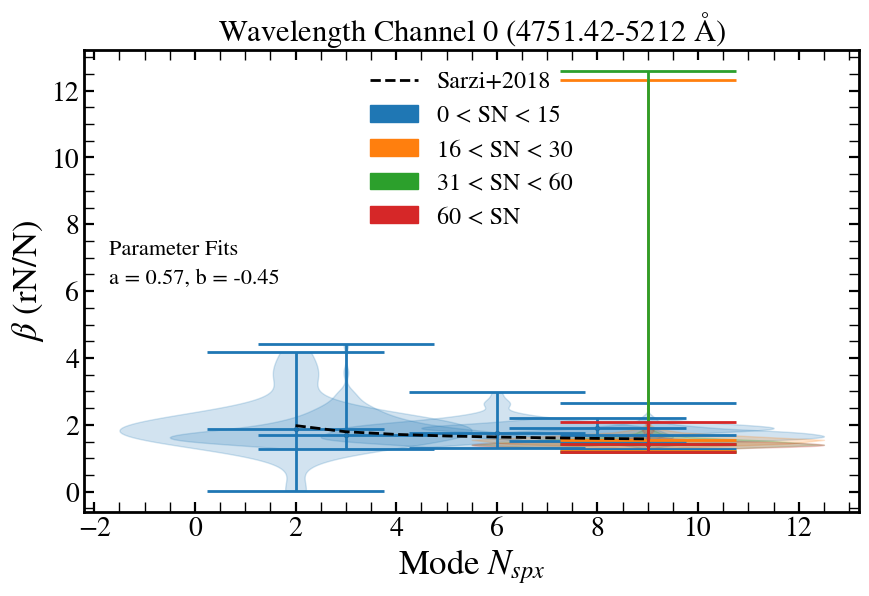

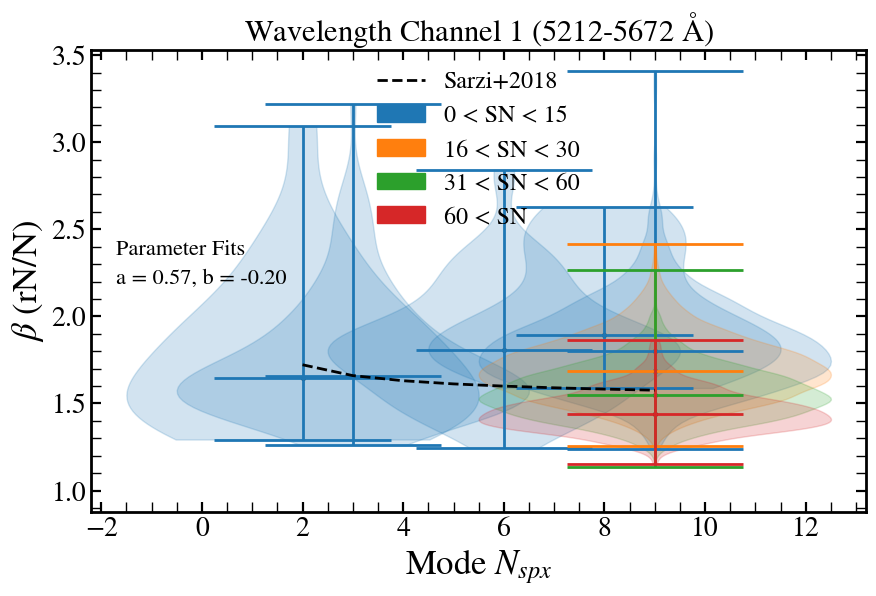

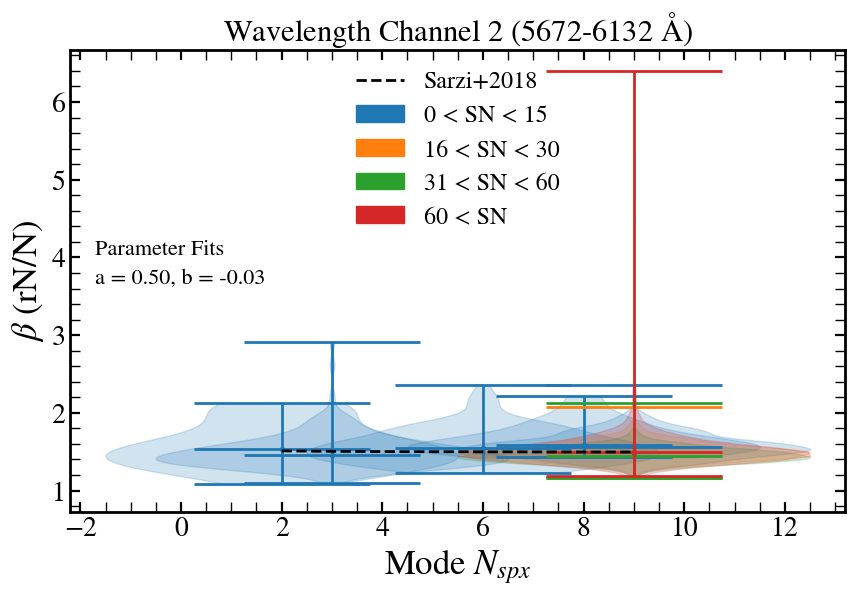

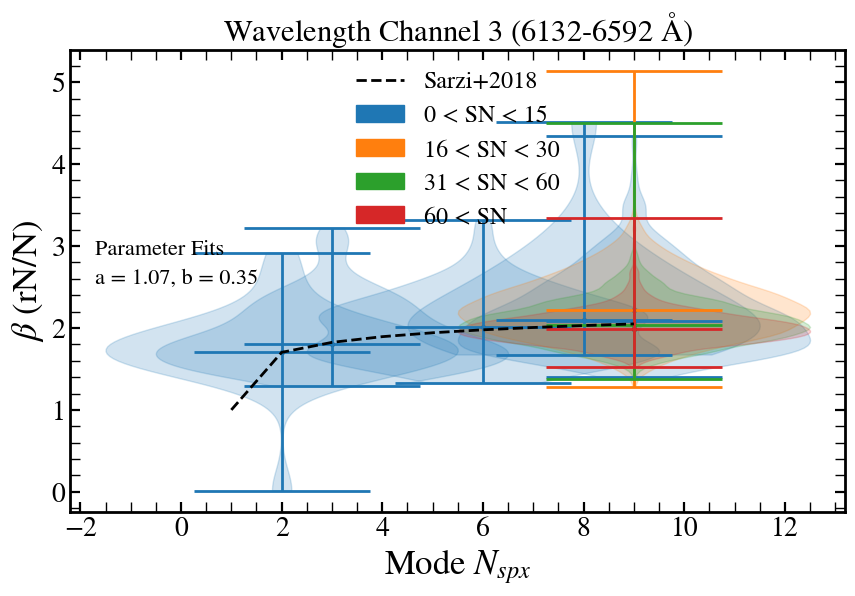

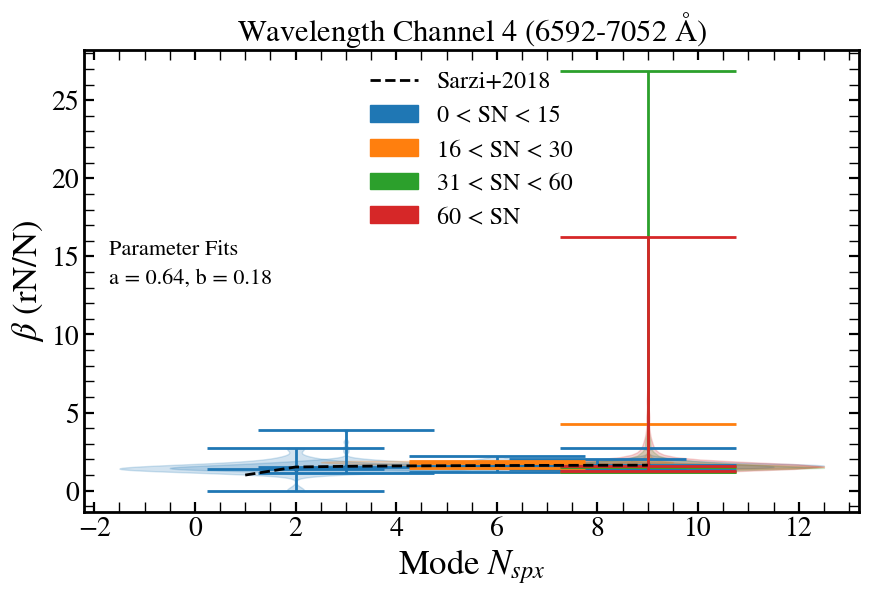

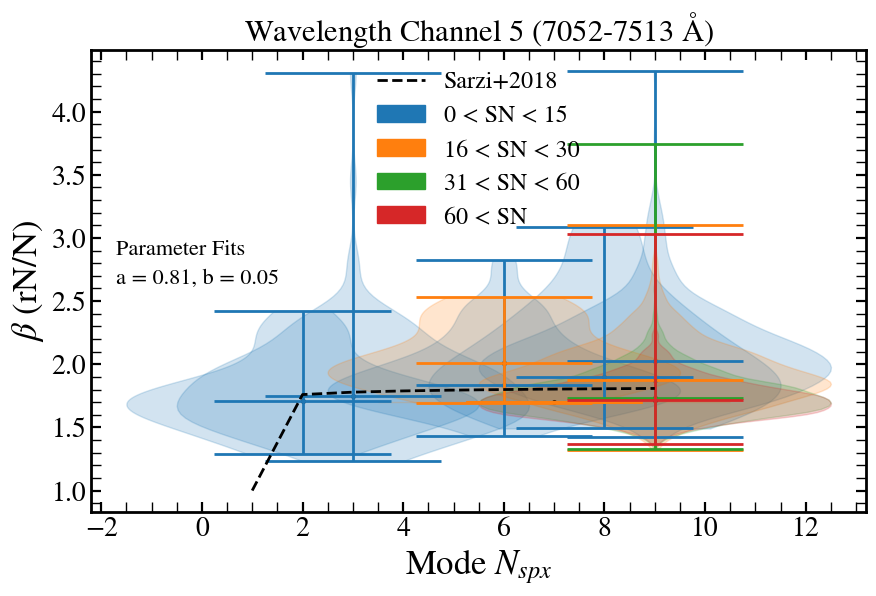

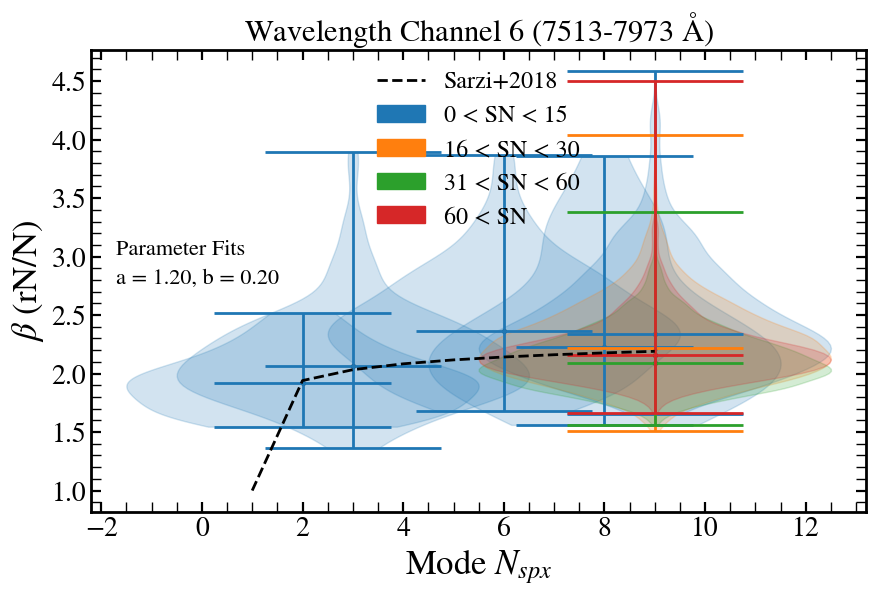

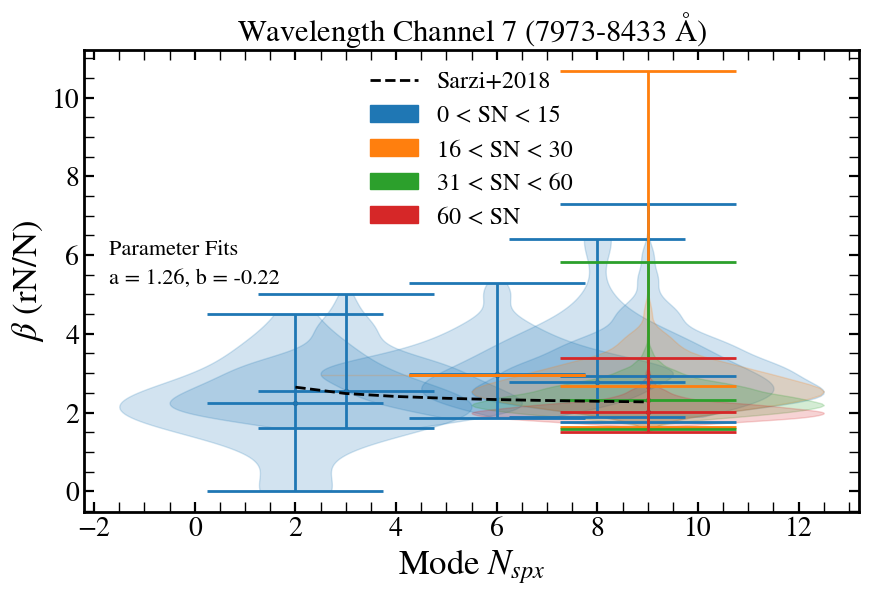

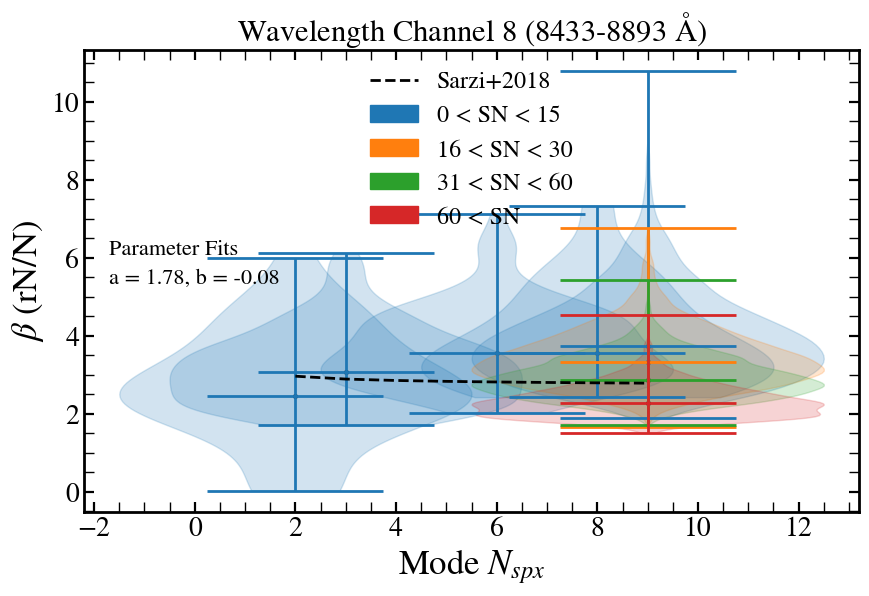

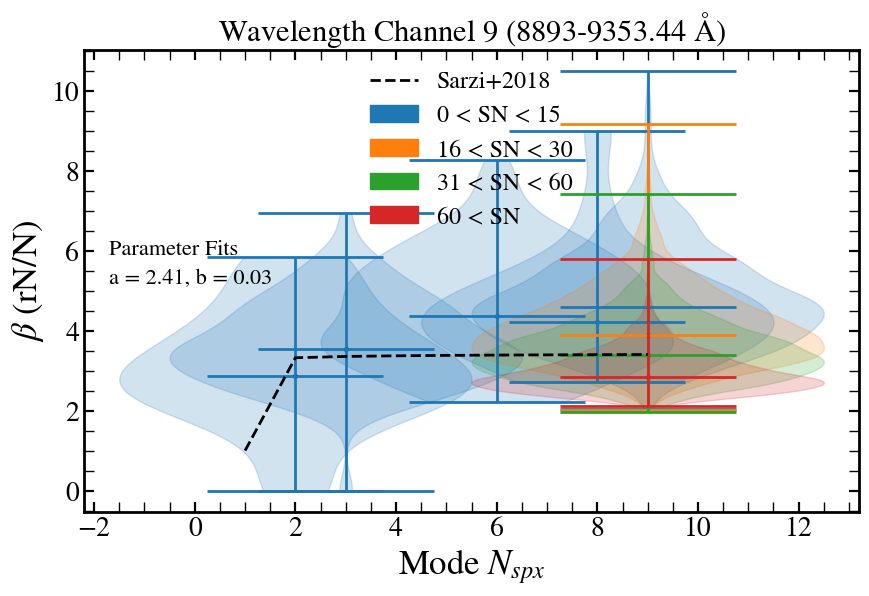

In [34]:
cube.mk_violin_plots(show_plots=True, save_plots=False)

In [11]:
dictionary = cube.wv_dict

In [22]:
betas = dictionary['WAVE_CHANNEL0']['N_spx_dict']['N_spx_CHANNEL0']['SN_dict']['SN_CHANNEL0']['beta_bin']

In [31]:
np.max(betas[betas<1000000])

4.411328315734863

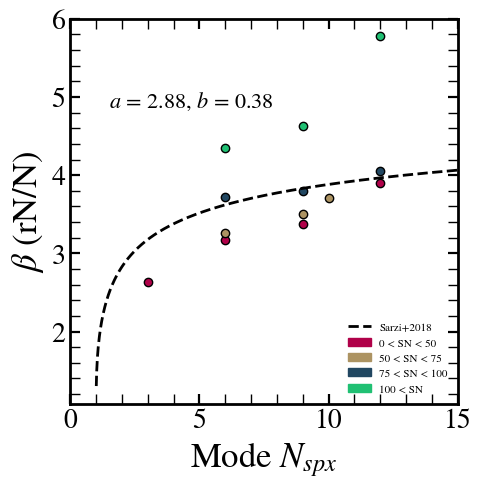

In [155]:
wvchannel=9
cube.make_scatter_plot_only(wvchannel,show_plot=True,save_plot=False)

In [16]:
cubefil = "data/NGC0289/cube/NGC0289-SQUARE0.6/NO-CORR/SQUARE0.6-MILESHC-MASTARHC2-NOISM/100000/0/manga-100000-0-LOGCUBE-SQUARE0.6-MILESHC-MASTARHC2-NOISM.fits"
cube = fits.open(cubefil)
binid = cube['BINID'].data[0]
flux = cube['FLUX'].data
mask = cube['MASK'].data.astype(bool)
ivar = cube['IVAR'].data

In [27]:
spaxs=[]
for ID in np.unique(binid)[1:]:
    nspx = np.sum(binid==ID)
    spaxs.append(nspx)

spaxs = np.array(spaxs)

In [31]:
np.sum(spaxs==9)

10855

In [91]:
w = binid == 1000
inds = np.where(binid==1000)

In [96]:
test={}
test['1']=1
test['1']+=1
test

{'1': 2}

In [99]:
bincount = {}
for ID in tqdm(np.unique(binid)[1:]):
    w = binid == ID
    nspax = np.sum(w)
    key = str(nspax)

    if key not in list(bincount.keys()):
        bincount[key] = 1
    else:
        bincount[key] += 1

100%|██████████████████████████████████| 11239/11239 [00:00<00:00, 29343.19it/s]


In [104]:
np.argsort(list(bincount.values()))

array([ 6,  9,  3,  0,  7,  8,  2, 10,  5,  4,  1])

In [108]:
keylist = [1,2,3,4,5,6,7,8,9,10,12]
for key in keylist:
    key = str(key)
    print(f"There are {bincount[key]:,} bins of size {int(key)} spaxels.")

There are 15 bins of size 1 spaxels.
There are 20 bins of size 2 spaxels.
There are 110 bins of size 3 spaxels.
There are 10 bins of size 4 spaxels.
There are 13 bins of size 5 spaxels.
There are 139 bins of size 6 spaxels.
There are 12 bins of size 7 spaxels.
There are 15 bins of size 8 spaxels.
There are 10,828 bins of size 9 spaxels.
There are 25 bins of size 10 spaxels.
There are 52 bins of size 12 spaxels.


In [6]:
10828/np.unique(binid).size

0.9633451957295374

In [92]:
snrdict = {}
for ID in tqdm(np.unique(binid)[1:]):

    w = binid == ID
    inds = np.where(binid==ID)
    
    nspax = np.sum(w)
    if nspax > 12:
        print(ID)
    key = str(nspax)

    
    fluxarr = flux[:,inds[0],inds[1]][:,0]
    ivararr = ivar[:,inds[0],inds[1]][:,0]
    maskarr = mask[:,inds[0],inds[1]][:,0]
    errorarr = 1 / np.sqrt(ivararr)

    warr = (fluxarr > 0 ) & (errorarr > 0)
    snrmask = np.logical_or(warr, ~maskarr)
    snrarr = fluxarr[snrmask]/errorarr[snrmask]

    if str(nspax) not in list(snrdict.keys()):
        snrdict[key] = snrarr
    else:
        values = snrdict[key]
        values = np.append(values, snrarr)
        snrdict[key] = values

100%|█████████████████████████████████████| 11239/11239 [02:28<00:00, 75.80it/s]


In [93]:
for key in sorted(snrdict.keys()):
    snr = snrdict[key]
    if len(snr) == 0:
        continue
    print(f"{key} spaxels: S/N: median = {np.median(snr):.2g}  std = {np.std(snr):.2g}  n_values = {len(snr):,}")

1 spaxels: S/N: median = 3.2  std = 2.9  n_values = 51,433
10 spaxels: S/N: median = 31  std = 23  n_values = 100,224
12 spaxels: S/N: median = 40  std = 32  n_values = 208,462
2 spaxels: S/N: median = 2.8  std = 3  n_values = 75,692
3 spaxels: S/N: median = 4.4  std = 3.3  n_values = 438,200
4 spaxels: S/N: median = 7.8  std = 4.9  n_values = 40,083
5 spaxels: S/N: median = 6.1  std = 3.3  n_values = 51,952
6 spaxels: S/N: median = 8.9  std = 22  n_values = 557,136
7 spaxels: S/N: median = 7.2  std = 31  n_values = 48,103
8 spaxels: S/N: median = 8.7  std = 34  n_values = 60,128
9 spaxels: S/N: median = 24  std = 20  n_values = 43,407,863


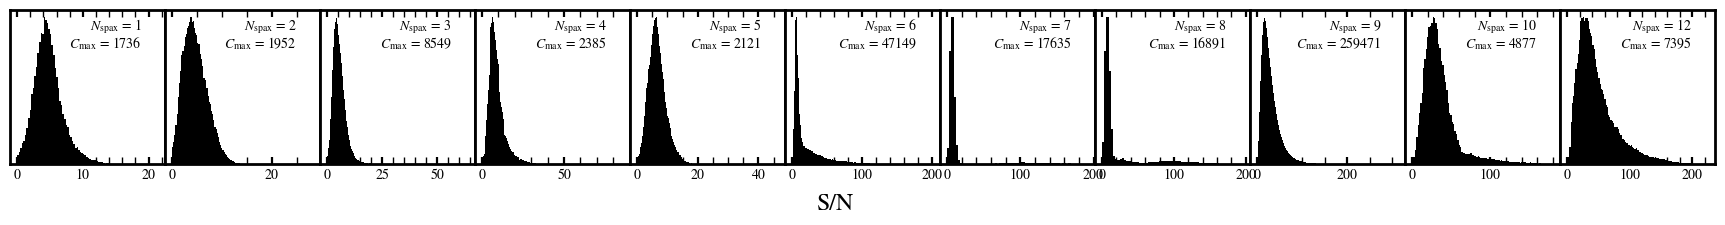

In [94]:
fig, ax = plt.subplots(1,11,figsize = (22,2))

keylist = [1,2,3,4,5,6,7,8,9,10,12]
#sorted(snrdict.keys())

for i,k in enumerate(keylist):
    key = str(k)
    snr = snrdict[key]
    snr = snr[np.isfinite(snr)]
    snr = snr[snr>0]

    bin_width = 3.5 * np.std(snr) / (snr.size ** (1/3))
    nbins = (max(snr) - min(snr)) / bin_width

    hist = np.histogram(snr, bins=int(nbins))
    
    ax[i].hist(snr, bins=int(nbins), color='k')
    latex = r"$N_{\mathrm{spax}}$"
    ax[i].text(0.85,0.87, s = f"{latex} = {key}", transform=ax[i].transAxes, ha='right')
    latex = r"$C_{\mathrm{max}}$"
    ax[i].text(0.85,0.75, s = f"{latex} = {np.max(hist[0])}", transform=ax[i].transAxes, ha='right')
    #ax[i].text(0.5,0.8, s = f"Pea", transform=ax[i].transAxes, ha='center')
    
    ax[i].get_yaxis().set_visible(False)
    ax[i].tick_params(axis='x', labelsize='medium')
    ax[i].tick_params(axis='x',which='both', length=5)
    
fig.subplots_adjust(wspace=0)
fig.text(0.5,-0.12,"S/N", ha='center',fontsize='xx-large')
plt.savefig('bin_snr_dists.pdf',bbox_inches='tight',dpi=500)
#fig.text(0.1,0.5,"Counts", va='center',rotation='vertical',fontsize='xx-large')

In [95]:
galnames = ["NGC4030", "NGC0289", "NGC1097", "NGC1084", "NGC1483"]
lamrest = 5897.558
outfracs={}
infracs={}
for gal in galnames:
    filpath = f"data/{gal}/mcmc/{gal}-SQUARE0.6/BETA-CORR/"
    mcmc_fils = glob(f"{filpath}/**/*.fits",recursive=True)

    nspx=0
    nin=0
    nout=0
    for fil in mcmc_fils:
        mcmc = fits.open(fil)
        table = Table(mcmc[1].data)
        nspx += len(table)

        for row in table['percentiles']:
            lam = row[0][0]
            plus = row[0][1]
            minus = row[0][2]

            if lam+plus > lamrest and lam-minus > lamrest:
                nin += 1
            elif lam+plus < lamrest and lam-minus < lamrest:
                nout +=1

    outfracs[gal] = nout/nspx
    infracs[gal] = nin/nspx
    print(f"{gal} shows {nout}/{nspx} ({nout/nspx:.2f}) outflow spaxels and {nin}/{nspx} ({nin/nspx:.2f}) inflow spaxels.")

NGC4030 shows 3747/11255 (0.33) outflow spaxels and 2999/11255 (0.27) inflow spaxels.
NGC0289 shows 1518/11201 (0.14) outflow spaxels and 3842/11201 (0.34) inflow spaxels.


KeyboardInterrupt: 

In [70]:
galnames = ["NGC4030", "NGC0289", "NGC1097", "NGC1084", "NGC1483"]
lamrest = 5897.558
outfracs={}
infracs={}
for gal in galnames:
    filpath = f"data/{gal}/mcmc/{gal}-SQUARE0.6/BETA-CORR/"
    mcmc_fils = glob(f"{filpath}/**/*.fits",recursive=True)

    nspx=0
    nin=0
    nout=0
    for fil in mcmc_fils:
        mcmc = fits.open(fil)
        table = Table(mcmc[1].data)
        nspx += len(table)

        for row in table['samples']:
            samples = row[0, 1000:, 0]
            if np.sum(samples < lamrest)/len(samples) >= 0.95:
                nout+=1
            elif np.sum(samples > lamrest)/len(samples) >= 0.95:
                nin+=1
            
            
    outfracs[gal] = nout/nspx
    infracs[gal] = nin/nspx
    print(f"{gal} shows {nout}/{nspx} ({nout/nspx:.2f}) outflow spaxels and {nin}/{nspx} ({nin/nspx:.2f}) inflow spaxels.")

NGC4030 shows 4756/11255 (0.42) outflow spaxels and 4030/11255 (0.36) inflow spaxels.
NGC0289 shows 3219/11201 (0.29) outflow spaxels and 5534/11201 (0.49) inflow spaxels.
NGC1097 shows 6007/11030 (0.54) outflow spaxels and 3685/11030 (0.33) inflow spaxels.
NGC1084 shows 5863/10441 (0.56) outflow spaxels and 2450/10441 (0.23) inflow spaxels.
NGC1483 shows 2121/8421 (0.25) outflow spaxels and 4140/8421 (0.49) inflow spaxels.


In [23]:
datadir = "data/NGC4030/mcmc/NGC4030-SQUARE0.6/BETA-CORR/"

In [24]:
cubepath = "data/NGC4030/cube/NGC4030-SQUARE0.6/BETA-CORR/SQUARE0.6-MILESHC-MASTARHC2-NOISM/1/1/manga-1-1-LOGCUBE-SQUARE0.6-MILESHC-MASTARHC2-NOISM.fits"
mappath = "data/NGC4030/cube/NGC4030-SQUARE0.6/BETA-CORR/SQUARE0.6-MILESHC-MASTARHC2-NOISM/1/1/manga-1-1-MAPS-SQUARE0.6-MILESHC-MASTARHC2-NOISM.fits"

In [25]:
cube = fits.open(cubepath)
Map = fits.open(mappath)

In [26]:
mcmc_fils = glob(f"{datadir}/**/*.fits",recursive=True)

In [27]:
mcmc_fils

['data/NGC4030/mcmc/NGC4030-SQUARE0.6/BETA-CORR/NGC4030-SQUARE0.6-binid-1400-2100-samples-run-2.fits',
 'data/NGC4030/mcmc/NGC4030-SQUARE0.6/BETA-CORR/NGC4030-SQUARE0.6-binid-2100-2800-samples-run-3.fits',
 'data/NGC4030/mcmc/NGC4030-SQUARE0.6/BETA-CORR/NGC4030-SQUARE0.6-binid-0-700-samples-run-0.fits',
 'data/NGC4030/mcmc/NGC4030-SQUARE0.6/BETA-CORR/NGC4030-SQUARE0.6-binid-8400-9100-samples-run-12.fits',
 'data/NGC4030/mcmc/NGC4030-SQUARE0.6/BETA-CORR/NGC4030-SQUARE0.6-binid-9800-10500-samples-run-14.fits',
 'data/NGC4030/mcmc/NGC4030-SQUARE0.6/BETA-CORR/NGC4030-SQUARE0.6-binid-9100-9800-samples-run-13.fits',
 'data/NGC4030/mcmc/NGC4030-SQUARE0.6/BETA-CORR/NGC4030-SQUARE0.6-binid-4900-5600-samples-run-7.fits',
 'data/NGC4030/mcmc/NGC4030-SQUARE0.6/BETA-CORR/NGC4030-SQUARE0.6-binid-4200-4900-samples-run-6.fits',
 'data/NGC4030/mcmc/NGC4030-SQUARE0.6/BETA-CORR/NGC4030-SQUARE0.6-binid-5600-6300-samples-run-8.fits',
 'data/NGC4030/mcmc/NGC4030-SQUARE0.6/BETA-CORR/NGC4030-SQUARE0.6-binid-7

In [28]:
test = fits.open(mcmc_fils[0])

In [29]:
datatable = Table(test[1].data)

In [35]:
len(datatable)

701

In [54]:
datatable['samples'].shape

(701, 100, 1100, 4)

In [68]:
np.median(datatable['samples'][0][:,1000:,0])

5897.3081101388425

In [66]:
datatable['percentiles'].shape

(701, 4, 3)

In [67]:
datatable['percentiles'][0][0,0]

5897.3081101388425

In [192]:
lamrest = 5897.558

In [211]:
datatable['velocities'][0]

-12.708134299691975

In [217]:
2.998e5 * ((np.median(datatable['samples'][0][:,:,0])/lamrest) - 1)

8.447902530746916

In [220]:
lamred_mcmc, logN_mcmc, bD_mcmc, Cf_mcmc = datatable['percentiles'][0]

In [225]:
lamred_mcmc[0]

5897.3081101388425

In [196]:
inflow = np.sum(datatable['samples'][0][:,:,0] < lamrest)
outflow = np.sum(datatable['samples'][0][:,:,0] > lamrest)
nsamples = datatable['samples'][0][:,:,0].size

In [197]:
inflow/nsamples

0.4440090909090909

In [198]:
outflow/nsamples

0.5559909090909091

In [182]:
datatable['percentiles'][0]

array([[5.89730811e+03, 1.24284916e+00, 5.87336870e-01],
       [1.49296892e+01, 1.05862409e+00, 1.82579692e+00],
       [7.43568035e+01, 1.62362901e+01, 1.69379051e+01],
       [8.61199749e-02, 3.26539390e-01, 1.32405973e-02]], dtype='>f8')

In [50]:
cube = fits.open(cubepath)
binid = cube['BINID'].data[0]

table = None
for i,fil in enumerate(tqdm(mcmc_fils, desc= "Combining Tables")):
    data = fits.open(fil)
    data_table = Table(data[1].data)
    data_table.remove_columns(['samples','percentiles'])
    data_table['id'] = np.arange(len(data_table))
    if i == 0:
        table = data_table
        continue
    table = join(table, data_table, join_type='outer')

Combining Tables: 100%|█████████████████████████| 17/17 [01:04<00:00,  3.80s/it]


# EW map

In [14]:
flux = cube['FLUX'].data
wave = cube['WAVE'].data
ivar = cube['IVAR'].data
model = cube['MODEL'].data
binid = Map['BINID'].data[0]
stellarvel = Map['STELLAR_VEL'].data

z_guess=0.01

In [22]:
inds

(array([162, 162, 163, 163, 163, 164, 164, 164]),
 array([160, 161, 159, 160, 161, 159, 160, 161]))

In [30]:
bins = np.random.rand(10,10)

In [33]:
w = bins > 0.8

In [41]:
arr =  np.zeros((100,10,10))
values = np.random.rand(100)

inds = (np.array([2,3,4,5]), np.array([5,6,7,8]))

for y,x in zip(inds[0],inds[1]):
    arr[np.arange(100),y,x] = values

In [45]:
arr[:,3,6]

array([0.58887996, 0.40685785, 0.39410248, 0.02175126, 0.02606358,
       0.62225853, 0.92211122, 0.82374667, 0.25184969, 0.57984596,
       0.23527353, 0.58933369, 0.35719365, 0.00972674, 0.6683072 ,
       0.64426263, 0.20634349, 0.40830759, 0.09236087, 0.80042608,
       0.95648956, 0.75661247, 0.04089783, 0.48817994, 0.487328  ,
       0.32886068, 0.14448527, 0.40060692, 0.84537462, 0.57791486,
       0.40001358, 0.56727548, 0.20909275, 0.66084347, 0.60551182,
       0.4816457 , 0.96200879, 0.9144578 , 0.98972012, 0.18494814,
       0.55297962, 0.74219815, 0.50470365, 0.658662  , 0.97905935,
       0.49448148, 0.83455744, 0.85054419, 0.33697375, 0.54434909,
       0.71313987, 0.94401403, 0.52641143, 0.59375145, 0.54008943,
       0.791435  , 0.69079203, 0.91043655, 0.05495296, 0.77014442,
       0.88122104, 0.62501521, 0.10525275, 0.74810264, 0.28741016,
       0.30972455, 0.86807274, 0.24426208, 0.66201271, 0.23705285,
       0.81678629, 0.36783443, 0.24672001, 0.05048244, 0.57330

In [26]:
arr[:,inds[0],inds[1]]

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],


In [17]:
l, ny, nx = flux.shape
ewmap = np.zeros((ny,nx))
wavecube = np.zeros(flux.shape)
uniqids = np.unique(binid)
c = 2.998e5
for ID in uniqids[1:]:
    inds = np.where(binid == ID)
    w = binid == ID
    
    ## get the stellar velocity of the bin
    sv = stellarvel[w][0]
        
    ## Calculate redshift
    z = (sv * (1+z_guess))/c + z_guess

    # shift wavelengths to restframe
    restwave = wave / (1+z)
    wavecube[np.arange(len(restwave)),inds[0],inds[1]] = restwave

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (4009,) (8,) (8,) 

In [ ]:
def make_EW_map(cubefil,mapfil,z_guess,savepath,vmin=-0.2,vmax=4,bad_bins=False,show_warnings=True):
    c = 2.998e5
    
    if isinstance(z_guess, str):
        z_guess = float(z_guess)
        
    if bad_bins:
        bbins=[]
        
    cube = fits.open(cubefil)
    Map = fits.open(mapfil)
    
    flux = cube['FLUX'].data
    wave = cube['WAVE'].data
    ivar = cube['IVAR'].data
    model = cube['MODEL'].data
    
    stellarvel = Map['STELLAR_VEL'].data
    binid = Map['BINID'].data[0]
    uniqids = np.unique(binid)
    
    region = 5880, 5910
    
    
    l, ny, nx = flux.shape
    ewmap = np.zeros((ny,nx))
    wavecube = np.zeros(flux.shape)

    logging.info('Constructing equivalent width map.')
    for ID in uniqids[1:]:
        inds = np.where(binid == ID)
        w = binid == ID

        ## get the stellar velocity of the bin
        sv = stellarvel[w][0]
            
        ## Calculate redshift
        z = (sv * (1+z_guess))/c + z_guess

        # shift wavelengths to restframe
        restwave = wave / (1+z)
        wavecube[np.arange(len(restwave)),inds[0],inds[1]] = restwave

        # define wavelength boundaries and slice flux, model, and wavelength arrays
        inbounds = np.where((restwave>region[0]) & (restwave<region[1]))[0]
        Lam = restwave[inbounds]
        fluxbound = flux[inbounds,:,:]
        modelbound = model[inbounds,:,:]       

        ## check the flux and model in the bin
        
        # slice the flux/model to just those in the current bin
        fluxbin = fluxbound[:,inds[0],inds[1]]
        modelbin = modelbound[:,inds[0],inds[1]]

        if abs(sv) > 4 * np.std(stellarvel):
            if show_warnings:
                warnings.warn(f"Stellar velocity in Bin ID {ID} beyond 4 standard deviations. Bin {ID} EW set to Nan",UserWarning,
                             stacklevel=2)
            ewmap[w] = np.nan
            if bad_bins:
                bbins.append(ID)
            continue

        # make sure flux is identical throughout the bin
        if not np.all(fluxbin == fluxbin[:,0][:,np.newaxis]):
            if show_warnings:
                warnings.warn(f"Fluxes in Bin {ID} are not identical. Bin {ID} EW set to NaN",UserWarning,
                             stacklevel=2)
            ewmap[w] = np.nan
            if bad_bins:
                bbins.append(ID)
            continue
            
        # repeat comparison for the model
        if not np.all(modelbin == modelbin[:,0][:,np.newaxis]):
            if show_warnings:
                warnings.warn(f"Stellar models in Bin {ID} not identical. Bin {ID} EW set to NaN",UserWarning,
                             stacklevel=2)
            ewmap[w] = np.nan
            if bad_bins:
                bbins.append(ID)
            continue
         
        F = fluxbin[:,0]
        M = modelbin[:,0]
        
        if not all(F>=0) or not all(M>=0):
            if show_warnings:
                warnings.warn(f"Flux or model arrays in Bin {ID} contain values < 0. Logging Bin ID.", UserWarning,
                             stacklevel=2)
            #ewmap[w] = np.nan
            if bad_bins:
                bbins.append(ID)
            #continue
            
            
        # create dlambda array
        dLam = np.diff(Lam)
        dLam = np.insert(dLam, 0, dLam[0])
        
        # exclude models equal to zero to avoid nan in calculation
        nonzero = (M != 0) & (F != 0)
        cont = np.ones(np.sum(nonzero))
        W = np.sum( (cont - (F[nonzero])/M[nonzero]) * dLam[nonzero] )
        ewmap[w] = W
    
    logging.info('Creating plots.')
    
    flatew = ewmap.flatten()
    w = (flatew != 0) & (np.isfinite(flatew))
    flatewcleaned = flatew[w]
    
    bin_width = 3.5 * np.std(flatewcleaned) / (flatewcleaned.size ** (1/3))
    nbins = (max(flatewcleaned) - min(flatewcleaned)) / bin_width
    
    plt.hist(flatewcleaned,bins=int(nbins),color='k')
    plt.xlim(-5,5)
    plt.xlabel(r'$\mathrm{EW_{Na\ I}\ (\AA)}$')
    plt.ylabel(r'$N_{\mathrm{spax}}$')
    
    im2name = f"{args.galname}-EW_distribution.png"
    output = os.path.join(savepath,im2name)
    plt.savefig(output,bbox_inches='tight',dpi=150)
    logging.info(f"EW distriubtion plot saved to {output}")
    plt.close()
    
    
    plotmap = np.copy(ewmap)
    plotmap[(plotmap==0) | (plotmap>vmax) | (plotmap<vmin)] = np.nan
    
    nvmax = np.median(plotmap[np.isfinite(plotmap)]) + np.std(plotmap[np.isfinite(plotmap)])
    if vmax < nvmax:
        vmax = np.round(nvmax)
 
    plt.imshow(plotmap,origin='lower',cmap='rainbow',vmin=vmin,vmax=vmax,
           extent=[32.4, -32.6,-32.4, 32.6])
    plt.colorbar(label=r'$\mathrm{EW_{Na\ I}\ (\AA)}$',fraction=0.0465, pad=0.01)
    plt.gca().set_facecolor('lightgray')
    plt.xlabel(r'$\Delta \alpha$ (arcsec)')
    plt.ylabel(r'$\Delta \delta$ (arcsec)')
    
    im1name = f"{args.galname}-EW_map.png"
    output = os.path.join(savepath,im1name)
    plt.savefig(output,bbox_inches='tight',dpi=200)
    logging.info(f"EW map plot saved to {output}")
    plt.close()
    
    if args.bokeh:
        logging.info("Creating BOKEH plot.")
        keyword = f"{args.galname}-EW-bokeh"
        make_bokeh_map(flux, model, ivar, wavecube, ewmap, binid, savepath, keyword)


    if bad_bins:
        return ewmap, bbins
    
    return ewmap

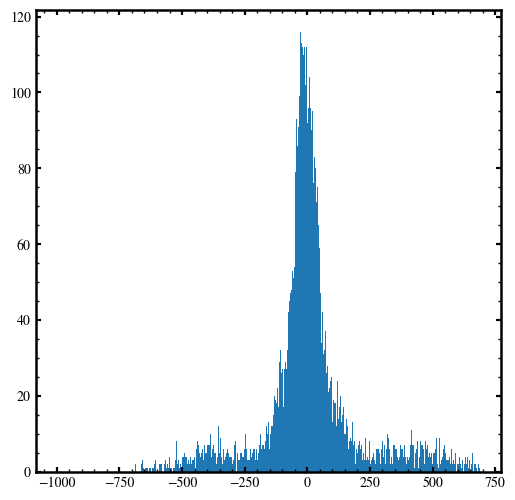

In [71]:
plt.hist(table['velocities'],bins=1000);

In [60]:
bins,inds = np.unique(table['bin'],return_index=True)

In [64]:
binid = cube['BINID'].data[0]

In [65]:
vmap = np.zeros(binid.shape)
for ID,ind in zip(bins,inds):
    w = binid == ID
    vmap[w] = table['velocities'][ind]

In [66]:
plt.style.use('figures.mplstyle')

In [78]:
round(np.std(table['velocities']),ndigits=-1)

210.0

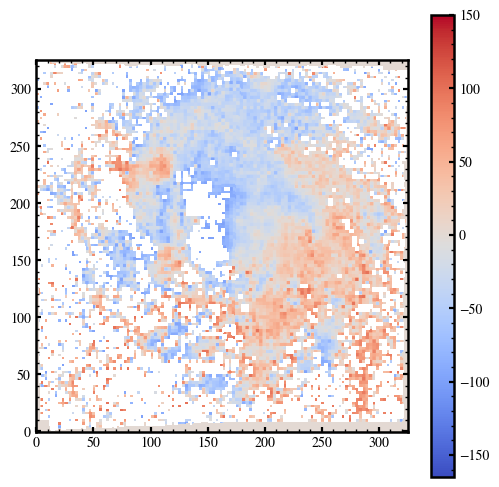

In [85]:
w = (vmap>100) | (vmap<-100)
vmap[w] = np.nan
plt.imshow(vmap,cmap='coolwarm',vmin=150,vmax=-150,origin='lower')
plt.colorbar()

In [92]:
testdir = "/Users/apitts4030/Repo/NaI_analysis/data/NGC4030/cube/BETA-CORR/"
testglob = glob(f"{testdir}/**/*.fits",recursive=True)
testglob

[]

In [4]:
testdir = "/Users/apitts4030/Repo/NaI_analysis/data/NGC4030/cube/NGC4030-SQUARE0.6/BETA-CORR/"

In [6]:
import os

In [7]:
fils = glob(os.path.join(testdir,"**","*.fits"),recursive=True)

In [8]:
for fil in fils:
    if "MAPS" in fil:
        mapfil = fil

In [9]:
Map = fits.open(mapfil)

In [10]:
Map.info()

Filename: /Users/apitts4030/Repo/NaI_analysis/data/NGC4030/cube/NGC4030-SQUARE0.6/BETA-CORR/SQUARE0.6-MILESHC-MASTARHC2-NOISM/1/1/manga-1-1-MAPS-SQUARE0.6-MILESHC-MASTARHC2-NOISM.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1384   ()      
  1  SPX_SKYCOO    1 ImageHDU        44   (326, 326, 2)   float32   
  2  SPX_ELLCOO    1 ImageHDU        49   (326, 326, 4)   float32   
  3  SPX_MFLUX     1 ImageHDU        36   (326, 326)   float32   
  4  SPX_MFLUX_IVAR    1 ImageHDU        37   (326, 326)   float32   
  5  SPX_SNR       1 ImageHDU        34   (326, 326)   float32   
  6  BINID         1 ImageHDU        46   (326, 326, 5)   int32   
  7  BIN_LWSKYCOO    1 ImageHDU        44   (326, 326, 2)   float32   
  8  BIN_LWELLCOO    1 ImageHDU        49   (326, 326, 4)   float32   
  9  BIN_AREA      1 ImageHDU        35   (326, 326)   float32   
 10  BIN_FAREA     1 ImageHDU        34   (326, 326)   float32   
 11  BIN_MFLUX     1 I

In [11]:
Map['EMLINE_SFLUX'].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  326                                                  
NAXIS2  =                  326                                                  
NAXIS3  =                   35                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
WCSAXES =                    3 / Number of coordinate axes                      
CRPIX1  =      168.69830612546 / Pixel coordinate of reference point            
CRPIX2  =      162.60512922633 / Pixel coordinate of reference point            
CRPIX3  =                  1.0 / Pixel coordinate of reference point            
PC1_1   = -5.5555555555556E-

In [12]:
import os
os.path.dirname(os.path.abspath('maps'))

'/Users/apitts4030/Repo/NaI_analysis'

In [114]:
import astropy.units as u

test = 100 * u.m

In [13]:
dtype = []
dtype.append( ('OIII/HB', list) )
dtype.append( ('NII/HA', list) )
dtype.append( ('SII/HA', list) )
dtype.append( ('OI/HA', list) )
dtype.append( ('') )

In [14]:
emlines = Map['EMLINE_SFLUX'].data
ivars = Map['EMLINE_SFLUX_IVAR'].data
binid = Map['BINID'].data[0]


ha = emlines[23]
hb = emlines[14]

oiii = emlines[15] #oiii 4690
#oiii = emlines[16] #oiii 5007 

oiii_hb = oiii/hb

sii = emlines[25] # sii 6718
#sii = emlines[26] # sii 6732

sii_ha = sii/ha

oi = emlines[20] # oi 6302
#oi = emlines[21] # oi 6365

oi_ha = oi/ha

nii = emlines[22] # nii 6549
#nii = emlines[24] # nii 6585

nii_ha = nii/ha

fake_niiha = np.linspace(np.min(nii_ha),np.max(nii_ha),10000)
fake_siiha = np.linspace(np.min(sii_ha),np.max(sii_ha),10000)
fake_oiha = np.linspace(np.min(oi_ha),np.max(oi_ha),10000)

/var/folders/ms/1cj6qz8d54qg6yvchfl0610c0000gt/T/ipykernel_4225/4175704624.py:12: RuntimeWarning: invalid value encountered in divide
  oiii_hb = oiii/hb
/var/folders/ms/1cj6qz8d54qg6yvchfl0610c0000gt/T/ipykernel_4225/4175704624.py:17: RuntimeWarning: divide by zero encountered in divide
  sii_ha = sii/ha
/var/folders/ms/1cj6qz8d54qg6yvchfl0610c0000gt/T/ipykernel_4225/4175704624.py:17: RuntimeWarning: invalid value encountered in divide
  sii_ha = sii/ha
/var/folders/ms/1cj6qz8d54qg6yvchfl0610c0000gt/T/ipykernel_4225/4175704624.py:22: RuntimeWarning: divide by zero encountered in divide
  oi_ha = oi/ha
/var/folders/ms/1cj6qz8d54qg6yvchfl0610c0000gt/T/ipykernel_4225/4175704624.py:22: RuntimeWarning: invalid value encountered in divide
  oi_ha = oi/ha
/var/folders/ms/1cj6qz8d54qg6yvchfl0610c0000gt/T/ipykernel_4225/4175704624.py:27: RuntimeWarning: invalid value encountered in divide
  nii_ha = nii/ha


In [15]:
def demarcation2(ratio):
    w = np.isfinite(ratio)
    fake_ratio = np.linspace(np.min(ratio[w]),np.max(ratio[w]),1000)
    demarc_line = 0.61 / np.log10((fake_ratio) - 0.05) + 1.3

    return np.log10(fake_ratio), np.log10(demarc_line)

In [16]:
def demarcation(ratio):
    return 0.61 / np.log10((ratio) - 0.05) + 1.3

In [17]:
def setup_elrs(emlines):
    ha = emlines[23]
    hb = emlines[14]
    oiii = emlines[15] #oiii 4690
    #oiii = emlines[16] #oiii 5007     
    sii = emlines[25] # sii 6718
    #sii = emlines[26] # sii 6732
    oi = emlines[20] # oi 6302
    #oi = emlines[21] # oi 6365
    nii = emlines[22] # nii 6549
    #nii = emlines[24] # nii 6585
    global sii_ha = sii/ha
    global oiii_hb = oiii/hb    
    global oi_ha = oi/ha
    global nii_ha = nii/ha
    
    ELRs = []

SyntaxError: invalid syntax (416652209.py, line 12)

/var/folders/ms/1cj6qz8d54qg6yvchfl0610c0000gt/T/ipykernel_4225/2509924260.py:2: RuntimeWarning: invalid value encountered in log10
  ax[0].plot(np.log10(nii_ha.flatten()),np.log10(oiii_hb.flatten()),'v')
/var/folders/ms/1cj6qz8d54qg6yvchfl0610c0000gt/T/ipykernel_4225/2509924260.py:2: RuntimeWarning: divide by zero encountered in log10
  ax[0].plot(np.log10(nii_ha.flatten()),np.log10(oiii_hb.flatten()),'v')


NameError: name 'line' is not defined

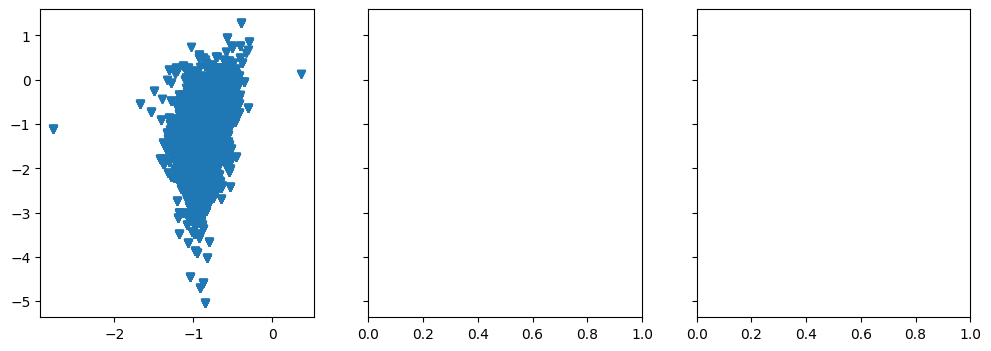

In [18]:
fig, ax = plt.subplots(1,3,figsize=(12,4),sharey=True)
ax[0].plot(np.log10(nii_ha.flatten()),np.log10(oiii_hb.flatten()),'v')
ax[0].plot(line, demarc, 'k', linestyle='dotted')
ax[0].set_ylabel(r"$\mathrm{log\ ([O\ III]/H \beta)}$")
ax[0].set_xlabel(r"$\mathrm{log\ ([N\ II]/H \alpha)}$")

ax[1].plot(np.log10(sii_ha.flatten()),np.log10(oiii_hb.flatten()), 'v')
ax[1].plot(np.log10(fake_siiha), demarcation(fake_siiha), 'k', linestyle='dotted')
ax[1].set_xlabel(r"$\mathrm{log\ ([S\ II]/H \alpha)}$")

ax[2].plot(np.log10(oi_ha.flatten()),np.log10(oiii_hb.flatten()), 'v')
ax[2].plot(np.log10(fake_oiha), demarcation(fake_oiha), 'k', linestyle='dotted')
ax[2].set_xlabel(r"$\mathrm{log\ ([O\ I]/H \alpha)}$")
fig.subplots_adjust(hspace=0,wspace=0)

In [19]:
oiii_hb.shape

(326, 326)

In [21]:
plt.style.use('figures.mplstyle')

/var/folders/ms/1cj6qz8d54qg6yvchfl0610c0000gt/T/ipykernel_4225/123829097.py:7: RuntimeWarning: invalid value encountered in divide
  oiii_hb = np.log10(oiii/hb)
/var/folders/ms/1cj6qz8d54qg6yvchfl0610c0000gt/T/ipykernel_4225/123829097.py:7: RuntimeWarning: divide by zero encountered in log10
  oiii_hb = np.log10(oiii/hb)
/var/folders/ms/1cj6qz8d54qg6yvchfl0610c0000gt/T/ipykernel_4225/123829097.py:7: RuntimeWarning: invalid value encountered in log10
  oiii_hb = np.log10(oiii/hb)
/var/folders/ms/1cj6qz8d54qg6yvchfl0610c0000gt/T/ipykernel_4225/123829097.py:11: RuntimeWarning: divide by zero encountered in divide
  sii_ha = np.log10(sii/ha)
/var/folders/ms/1cj6qz8d54qg6yvchfl0610c0000gt/T/ipykernel_4225/123829097.py:11: RuntimeWarning: invalid value encountered in divide
  sii_ha = np.log10(sii/ha)
/var/folders/ms/1cj6qz8d54qg6yvchfl0610c0000gt/T/ipykernel_4225/123829097.py:11: RuntimeWarning: invalid value encountered in log10
  sii_ha = np.log10(sii/ha)
/var/folders/ms/1cj6qz8d54qg6yvc

Text(0.5, 0, '$\\mathrm{(log[O\\ I]/H \\alpha)}$')

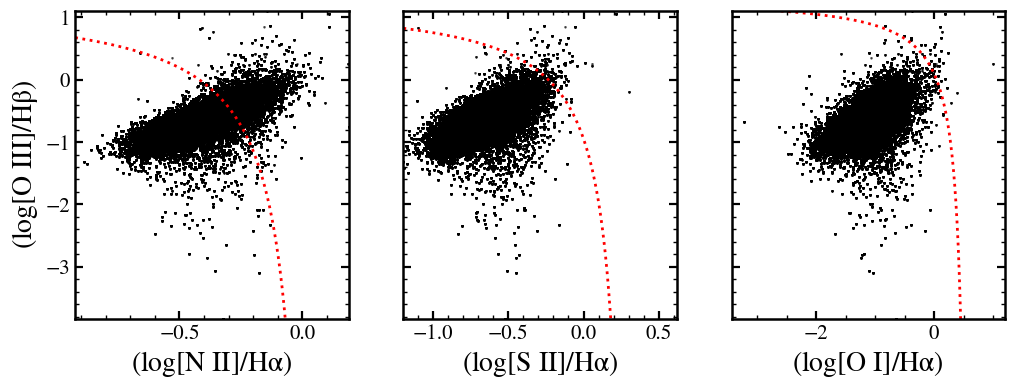

In [22]:
ha = emlines[23]
hb = emlines[14]

#oiii = emlines[15] #oiii 4690
oiii = emlines[16] #oiii 5007 

oiii_hb = np.log10(oiii/hb)

sii = emlines[25] + emlines[26] # sii 6718 + 6732

sii_ha = np.log10(sii/ha)

oi = emlines[20] # oi 6302
#oi = emlines[21] # oi 6365

oi_ha = np.log10(oi/ha)

#nii = emlines[22] # nii 6549
nii = emlines[24] # nii 6585

nii_ha = np.log10(nii/ha)

fake_niiha = np.linspace(np.min(nii_ha[np.isfinite(nii_ha)]),np.max(nii_ha[np.isfinite(nii_ha)]),1000)
fake_siiha = np.linspace(np.min(sii_ha[np.isfinite(sii_ha)]),np.max(sii_ha[np.isfinite(sii_ha)]),1000)
fake_oiha = np.linspace(np.min(oi_ha[np.isfinite(oi_ha)]),np.max(oi_ha[np.isfinite(oi_ha)]),1000)

fig, ax = plt.subplots(1,3,figsize=(12,4),sharey=True)



ax[0].plot(nii_ha,oiii_hb,'v',color='k',ms=1,alpha=0.75)

demarcation = lambda log_lr: 0.61 / (log_lr - 0.05) + 1.3
classification = demarcation(fake_niiha)
w = fake_niiha < 0.05
ax[0].plot(fake_niiha[w], classification[w], color='r', linestyle='dotted')
ax[0].set_ylabel(r"$\mathrm{(log[O\ III]/H \beta)}$")
ax[0].set_xlabel(r"$\mathrm{(log[N\ II]/H \alpha)}$")
ax[0].set_xlim(np.min(nii_ha[np.isfinite(nii_ha)]),np.max(nii_ha[np.isfinite(nii_ha)]))
ax[0].set_ylim(np.min(oiii_hb[np.isfinite(oiii_hb)]),np.max(oiii_hb[np.isfinite(oiii_hb)]))



ax[1].plot(sii_ha,oiii_hb, 'v', color='k',ms=1,alpha=0.75)

demarcation = lambda log_lr: 0.72 / (log_lr - 0.32) + 1.3
classification = demarcation(fake_siiha)
w = fake_siiha < 0.32
ax[1].plot(fake_siiha[w], classification[w], color='r', linestyle='dotted')
ax[1].set_xlabel(r"$\mathrm{(log[S\ II]/H \alpha)}$")

ax[0].set_xlim(np.min(nii_ha[np.isfinite(nii_ha)]),np.max(nii_ha[np.isfinite(nii_ha)]))
ax[0].set_ylim(np.min(oiii_hb[np.isfinite(oiii_hb)]),np.max(oiii_hb[np.isfinite(oiii_hb)]))
ax[1].set_xlim(np.min(sii_ha[np.isfinite(sii_ha)]),np.max(sii_ha[np.isfinite(sii_ha)]))
ax[1].set_ylim(np.min(oiii_hb[np.isfinite(oiii_hb)]),np.max(oiii_hb[np.isfinite(oiii_hb)]))


ax[2].plot(oi_ha,oiii_hb, 'v', color='k', ms=1, alpha=0.75)

demarcation = lambda log_lr: 0.73 / (log_lr - 0.59) + 1.33
classification = demarcation(fake_oiha)
w = fake_oiha < 0.59
ax[2].plot(fake_oiha[w], classification[w], color='r', linestyle='dotted')
ax[2].set_xlabel(r"$\mathrm{(log[O\ I]/H \alpha)}$")
plt.

In [179]:
ys, xs = np.where(5 == binid)

In [180]:
ys

array([177, 177, 177, 178, 178, 178, 179, 179, 179])

In [181]:
xs

array([159, 160, 161, 159, 160, 161, 159, 160, 161])

In [182]:
binid[ys,xs]

array([5, 5, 5, 5, 5, 5, 5, 5, 5], dtype='>i4')

In [203]:
test = np.zeros((5,5),dtype=str)

In [204]:
test

array([['', '', '', '', ''],
       ['', '', '', '', ''],
       ['', '', '', '', ''],
       ['', '', '', '', ''],
       ['', '', '', '', '']], dtype='<U1')

In [205]:
test[1,4] = 'test'

In [23]:
def BPT(map_fil, fig_output):
    """
    Creates spaxel-level BPT diagrams for individual galaxies using DAP emissionn line flux map and a new map
    containing color-coded classifications of each spaxel. Classifications are determined by Kewley et al. 2006.
    """

    logging.info("Obtaining Maps.")
    Map = fits.open(map_fil)
    emlines = Map['EMLINE_SFLUX'].data
    binid = Map['BINID'].data[0]


    ha = emlines[23]
    hb = emlines[14]

    #oiii = emlines[15] #oiii 4690
    oiii = emlines[16] #oiii 5007 

    oiii_hb = np.log10(oiii/hb)

    sii = emlines[25] + emlines[26] # sii 6718,32

    sii_ha = np.log10(sii/ha)

    oi = emlines[20] # oi 6302
    #oi = emlines[21] # oi 6365

    oi_ha = np.log10(oi/ha)

    #nii = emlines[22] # nii 6549
    nii = emlines[24] # nii 6585

    nii_ha = np.log10(nii/ha)

    fake_niiha = np.linspace(np.min(nii_ha[np.isfinite(nii_ha)]),np.max(nii_ha[np.isfinite(nii_ha)]),10000)
    fake_siiha = np.linspace(np.min(sii_ha[np.isfinite(sii_ha)]),np.max(sii_ha[np.isfinite(sii_ha)]),10000)
    fake_oiha = np.linspace(np.min(oi_ha[np.isfinite(oi_ha)]),np.max(oi_ha[np.isfinite(oi_ha)]),10000)



    logging.info("Creating BPT ELRs plot.")
    fig, ax = plt.subplots(1,3,figsize=(12,4),sharey=True)


    ax[0].plot(nii_ha,oiii_hb,'v',color='k',ms=1,alpha=0.35)

    demarcation = lambda log_lr: 0.61 / (log_lr - 0.05) + 1.3
    classification = demarcation(fake_niiha)
    w = fake_niiha < 0.05
    ax[0].plot(fake_niiha[w], classification[w], color='r')
    ax[0].set_ylabel(r"$\mathrm{(log[O\ III]/H \beta)}$")
    ax[0].set_xlabel(r"$\mathrm{(log[N\ II]/H \alpha)}$")



    ax[1].plot(sii_ha,oiii_hb, 'v', color='k',ms=1,alpha=0.35)
    
    demarcation = lambda log_lr: 0.72 / (log_lr - 0.32) + 1.3
    classification = demarcation(fake_siiha)
    w = fake_siiha < 0.32
    ax[1].plot(fake_siiha[w], classification[w], color='r')
    ax[1].set_xlabel(r"$\mathrm{(log[S\ II]/H \alpha)}$")


    ax[2].plot(oi_ha,oiii_hb, 'v', color='k',ms=1,alpha=0.35)

    demarcation = lambda log_lr: 0.73 / (log_lr - 0.59) + 1.33
    classification = demarcation(fake_oiha)
    w = fake_oiha < 0.59
    ax[2].plot(fake_oiha[w], classification[w], color='r')
    ax[2].set_xlabel(r"$\mathrm{(log[O\ I]/H \alpha)}$")


    ax[0].set_xlim(np.min(nii_ha[np.isfinite(nii_ha)]),np.max(nii_ha[np.isfinite(nii_ha)]))
    ax[0].set_ylim(np.min(oiii_hb[np.isfinite(oiii_hb)]),np.max(oiii_hb[np.isfinite(oiii_hb)]))
    ax[1].set_xlim(np.min(sii_ha[np.isfinite(sii_ha)]),np.max(sii_ha[np.isfinite(sii_ha)]))
    ax[1].set_ylim(np.min(oiii_hb[np.isfinite(oiii_hb)]),np.max(oiii_hb[np.isfinite(oiii_hb)]))
    ax[2].set_xlim(np.min(oi_ha[np.isfinite(oi_ha)]),np.max(oi_ha[np.isfinite(oi_ha)]))
    ax[2].set_ylim(np.min(oiii_hb[np.isfinite(oiii_hb)]),np.max(oiii_hb[np.isfinite(oiii_hb)]))
        #fig.set_box_aspect(0)
    fig.subplots_adjust(hspace=0,wspace=0)
    fig.savefig(fig_output,bbox_inches='tight',dpi=300)
    logging.info(f"BPT Plot saved to {fig_output}")
    
    logging.info("Creating classification map.")
    class_map = np.zeros(binid.shape, dtype=str)

    color_map = {
        'star-forming': np.array([119, 168, 212]), # blue
        'composite': np.array([235, 235, 240]), # white
        'seyfert': np.array([250, 209, 44]), # yellow
        'liners': np.array([51, 54, 82]), # dark blue
        'unk': np.array([0, 0, 0])
    }

    data3d = np.ndarray((binid.shape[0], binid.shape[0], 3), dtype=int)  

    for ID in np.unique(binid):
        w = binid == ID
        ys, xs = np.where(binid == ID)

        elrs = {
            'oiii':np.median(oiii_hb[w]),
            'nii':np.median(nii_ha[w]),
            'sii':np.median(sii_ha[w]),
            'oi':np.median(oi_ha[w])
        }

        classification_str = classify_ELR(elrs)
        class_map[w] = classification_str
        data3d[ys, xs] = color_map[classification_str]

    return data3d

In [24]:
def classify_ELR(elr_dict):
    if (elr_dict['oiii'] < 0.61 / (elr_dict['nii'] - 0.05) + 1.3) and (elr_dict['oiii'] < 0.72/(elr_dict['sii'] - 0.32) + 1.3) and (elr_dict['oiii'] < 0.73 / (elr_dict['oi'] + 0.59) + 1.33):
        return 'star-forming'
    
    elif (elr_dict['oiii'] >  0.61 / (elr_dict['nii'] - 0.05) + 1.3) and (elr_dict['oiii'] < 0.61 / (elr_dict['nii'] - 0.47) + 1.19):
        return 'composite'
    
    elif (elr_dict['oiii'] > 0.61 / (elr_dict['nii'] - 0.47) + 1.19) and (elr_dict['oiii'] > 0.72/(elr_dict['sii'] - 0.32) + 1.3) and (elr_dict['oiii'] > 0.73 / (elr_dict['oi'] + 0.59) + 1.33):
        return 'seyfert'
    
    elif (elr_dict['oi'] > - 0.59) and (elr_dict['oiii'] > 1.89 * elr_dict['sii'] + 0.76) and (elr_dict['oiii'] > 1.18 * elr_dict['oi'] + 1.3):
        return 'seyfert'
    
    elif (elr_dict['oiii'] > 0.61 / (elr_dict['nii'] - 0.47) + 1.19) and (elr_dict['oiii'] > 0.72/(elr_dict['sii'] - 0.32) + 1.3) and (elr_dict['oiii'] < 1.89 * elr_dict['sii'] + 0.76):
        return 'liners'
    
    elif (elr_dict['oi'] > -0.59) and (elr_dict['oiii'] < 1.18 * elr_dict['oi'] + 1.3):
        return 'liners'
    
    else:
        return 'unk'

In [27]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [28]:
map_fil = "data/NGC4030/cube/NGC4030-SQUARE0.6/BETA-CORR/SQUARE0.6-MILESHC-MASTARHC2-NOISM/1/1/manga-1-1-MAPS-SQUARE0.6-MILESHC-MASTARHC2-NOISM.fits"

INFO:root:Obtaining Maps.
/var/folders/ms/1cj6qz8d54qg6yvchfl0610c0000gt/T/ipykernel_4225/2596488095.py:19: RuntimeWarning: invalid value encountered in divide
  oiii_hb = np.log10(oiii/hb)
/var/folders/ms/1cj6qz8d54qg6yvchfl0610c0000gt/T/ipykernel_4225/2596488095.py:19: RuntimeWarning: divide by zero encountered in log10
  oiii_hb = np.log10(oiii/hb)
/var/folders/ms/1cj6qz8d54qg6yvchfl0610c0000gt/T/ipykernel_4225/2596488095.py:19: RuntimeWarning: invalid value encountered in log10
  oiii_hb = np.log10(oiii/hb)
/var/folders/ms/1cj6qz8d54qg6yvchfl0610c0000gt/T/ipykernel_4225/2596488095.py:23: RuntimeWarning: divide by zero encountered in divide
  sii_ha = np.log10(sii/ha)
/var/folders/ms/1cj6qz8d54qg6yvchfl0610c0000gt/T/ipykernel_4225/2596488095.py:23: RuntimeWarning: invalid value encountered in divide
  sii_ha = np.log10(sii/ha)
/var/folders/ms/1cj6qz8d54qg6yvchfl0610c0000gt/T/ipykernel_4225/2596488095.py:23: RuntimeWarning: invalid value encountered in log10
  sii_ha = np.log10(sii/h

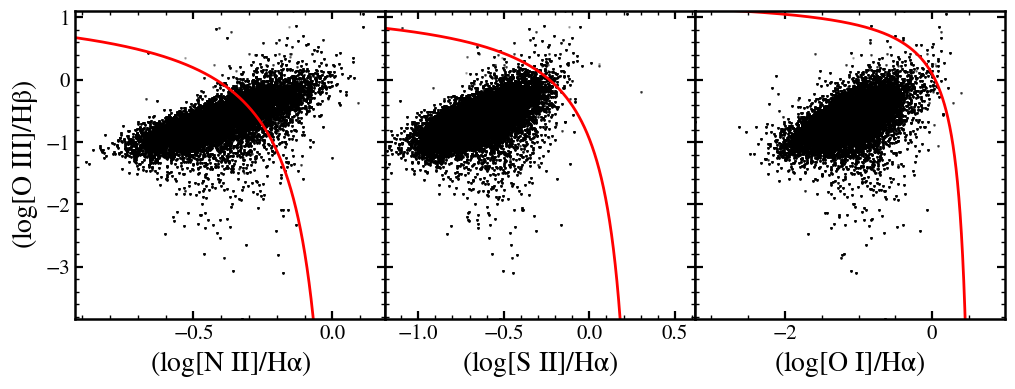

In [30]:
class_map = BPT(map_fil,fig_output="./paper/paper-plots/NGC4030/NGC4030-ELR.pdf")

In [223]:
class_map.shape

(326, 326, 3)

In [233]:
color_hex = {
        'star-forming': '#77a9d4', # blue
        'composite': '#ebebf0', # white
        'seyfert': '#fad12c', # yellow
        'liners': '#ff265b', # dark blue
        'unk': '#000000'
    }

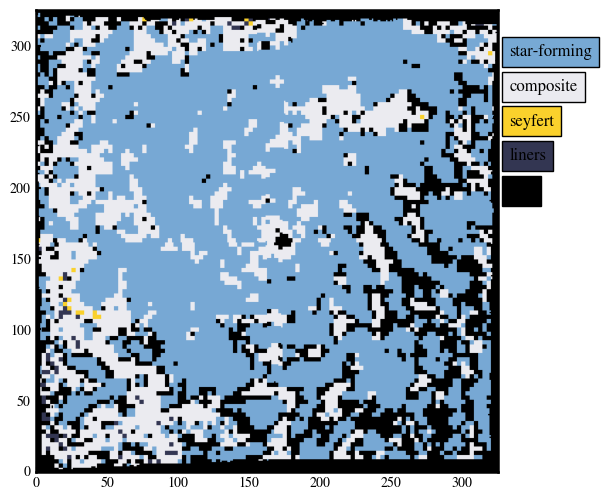

In [240]:
fig, ax = plt.subplots(1)
ax.imshow(class_map,origin='lower')

shift = 0
for cat in color_hex.keys():
    x = 1.025
    y = 0.9
    ax.text(x, y-shift, cat, fontsize='large', transform=ax.transAxes, bbox={'facecolor':color_hex[cat],'pad':5})
    shift += 0.075

In [244]:
(binid.shape[0] * .2)/2

32.6

In [248]:
cube.info()

Filename: data/NGC4030/cube/NGC4030-SQUARE0.6/BETA-CORR/SQUARE0.6-MILESHC-MASTARHC2-NOISM/1/1/manga-1-1-LOGCUBE-SQUARE0.6-MILESHC-MASTARHC2-NOISM.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1373   ()      
  1  FLUX          1 ImageHDU        45   (326, 326, 4009)   float32   
  2  IVAR          1 ImageHDU        46   (326, 326, 4009)   float32   
  3  MASK          1 ImageHDU        45   (326, 326, 4009)   int16   
  4  LSF           1 ImageHDU        43   (326, 326, 4009)   float32   
  5  WAVE          1 ImageHDU         9   (4009,)   float32   
  6  REDCORR       1 ImageHDU         9   (4009,)   float32   
  7  MODEL         1 ImageHDU        44   (326, 326, 4009)   float32   
  8  MODEL_MASK    1 ImageHDU        44   (326, 326, 4009)   int16   
  9  EMLINE        1 ImageHDU        43   (326, 326, 4009)   float32   
 10  STELLAR       1 ImageHDU        44   (326, 326, 4009)   float32   
 11  STELLAR_MASK    1 ImageHDU       

In [7]:
mapfil = "data/NGC4030/maps/NGC4030_EW-Map.fits"
ewmap = fits.getdata(mapfil)

In [6]:
from bokeh.plotting import figure, show

In [ ]:
plot = figure()

In [10]:
region = 5880, 5910

wave = cube['WAVE'].data

In [11]:
inds = np.where((wave>=region[0]) & (wave<=region[1]))

In [12]:
inds

(array([1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272,
        1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1281, 1282, 1283,
        1284, 1285, 1286, 1287, 1288, 1289, 1290, 1291]),)

In [14]:
len(inds[0])

30

In [28]:
5893 * (1+0.03)

6069.79